# `NPS-ActiveSpace.analysis` module sketch
purpose: **given an active space, vehicle tracks (as a subset of a transportation system), compute acoustic metrics attributive to the given subset**
v0.0.1 alpha <br>
TLogan@nps.gov, DBetchkal@nps.gov

In [4]:
# GEOSPATIAL LIBRARIES
import gdal
from gdalconst import GA_ReadOnly
import geopandas as gpd
import pyproj
import rasterio
import rasterio.plot
from rasterio.windows import Window
from shapely.geometry import Point, LineString
from scipy.interpolate import UnivariateSpline

# OTHER LIBRARIES
import datetime as dt
from datetime import timedelta
import geopy as geopy
from geopy.distance import geodesic
import glob
import ipykernel
from itertools import islice
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from matplotlib.widgets import RangeSlider, Button, Slider, RadioButtons
import numpy as np
from operator import sub
import os
import pandas as pd
import pickle
import re
from scipy import interpolate
from shapely.geometry import LineString
from shapely.prepared import prep
import sqlalchemy
import subprocess
import sys
import time
from time import mktime
from tqdm import tqdm
import warnings

# SPECIALIZED LIBRARIES
# =======================================================================================================
repo_dir = r"C:\Users\talogan\PythonScripts\3_GITHUB_REPOSITORIES" # ADJUST TO YOUR LOCAL DIRECTORY
# =======================================================================================================
sys.path.append(r"C:\Users\talogan\PythonScripts\GITHUB_REPOS\NPS-ActiveSpace-main")
sys.path.append(r"C:\Users\talogan\PythonScripts\GITHUB_REPOS\NPS-ActiveSpace-main\_DENA\resource")
sys.path.append(r"C:\Users\talogan\PythonScripts\GITHUB_REPOS\NPS-ActiveSpace-main\nps_active_space\utils")

import nps_active_space
from helpers import query_adsb, query_tracks
from computation import interpolate_spline, coords_to_utm

#path to load tracks from api
RDS = r"\\inpdenaterm01\overflights"
sys.path.append(os.path.join(RDS, "scripts"))
from query_tracks import query_tracks, get_mask_wkt


def get_aspect(ax):
    
    """
    Return the aspect ratio of a given `matplotlib` axis object.
    """
    
    # Total figure size
    figW, figH = ax.get_figure().get_size_inches()
    # Axis size on figure
    _, _, w, h = ax.get_position().bounds
    # Ratio of display units
    disp_ratio = (figH * h) / (figW * w)
    # Ratio of data units
    # Negative over negative because of the order of subtraction
    data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

    return disp_ratio / data_ratio


def load_activespace(u, s, y, gain, crs=None, PROJ_DIR=r"V:\NMSim\01 SITES"):
    
    '''The crucial input is an active space estimate, which will be taken as a 'given' logical condition in space.
       Provide a generalized loading process for this input
       with optional co-ordinate reference system conversion using `crs` parameter.
       
       Returns
       -------
       study_area : `gpd.GeoDataFrame` of user-defined study area polygon with designator metadata
    '''

    if gain < 0:
        sign = "-"
    else:
        sign = "+"
        
    if np.abs(gain) < 10:
        gain_string = "0" + str(np.abs(int(10*gain)))
    else:
        gain_string = str(np.abs(int(10*gain)))
    
    # find the estimate
    path = PROJ_DIR + os.sep + u+s + os.sep + u+s+str(y) + '_O_' + sign + gain_string + ".geojson"
    active_space = gpd.read_file(path) # read it in as a `gpd.GeoDataFrame`
    
    if crs is not None:
        active_space = active_space.to_crs(crs) # optional, user-defined coordinate reference system
    
    return active_space

def load_studyarea(u, s, y, crs=None, PROJ_DIR=r"V:\NMSim\01 SITES"):
    
    '''An important input is the Study Area polygon.
       Provide a generalized loading process 
       with optional co-ordinate reference system conversion using `crs` parameter.
       
       Returns
       -------
       study_area : `gpd.GeoDataFrame` of user-defined study area polygon with designator metadata
    '''

    # load in the study area as well
    study_area_path = glob.glob(PROJ_DIR + os.sep + u+s + os.sep + u+s + '*study*area*.shp')[0]
    study_area = gpd.read_file(study_area_path)
    
    if crs is not None:
        study_area = study_area.to_crs(crs)
        
    return study_area


def plot_by_id(col,id, df,active):
    
    """
    TO DO: write Docstring
    """
    
    condition = df[col] == id
    df_condition = df[condition]
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    df_condition.plot(ax=ax, color='red', zorder=1)
    active.boundary.plot(ax=ax, color="black", zorder=1)

    
def internal_interpolate_spline(points: 'Tracks', ds: int = 1) -> gpd.GeoDataFrame:
    
    """
    Interpolate points with a cubic spline between flight points, if possible.
    See https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html#spline-interpolation for docs

    Parameters
    ----------
    points : Tracks
        A Track gpd.GeoDataframe object containing known track points in a path. A minimum of 2 points is required.
    ds : int, default 1
        The second interval in which to calculate the spline for.
        E.g. ds = 1 is "calculate a spline point at every 1 second delta"

    Returns
    -------
    gpd.GeoDataFrame of all points in the interpolated spline.
    Columns: point_dt, geometry

    Raises
    ------
    AssertionError if there is fewer than 1 Track point.
    """
    # Calculate the order of polynomial to fit to the spline. The maximum is a cubic spline. If there are fewer than
    #  3 points, a cubic spline cannot be fit and lower order must be chosen.
    assert points.shape[0] > 1, "A minimum of 2 points is required for calculate a spline."
    k = min(points.shape[0] - 1, 3)

    points.sort_values(by='point_dt', ascending=True, inplace=True)
    starttime = points.point_dt.iat[0]
    endtime = points.point_dt.iat[-1]
    flight_times = (points.point_dt - starttime).dt.total_seconds().values  # Seconds after initial point

    coords = [points.geometry.x, points.geometry.y, points.z] if 'z' in points else [points.geometry.x, points.geometry.y]
    tck, u = interpolate.splprep(x=coords, u=flight_times, k=k)

    # Parametric interpolation on the time interval provided.
    duration = (endtime - starttime).total_seconds()
    tnew = np.arange(0, duration + ds, ds)
    spl_out = interpolate.splev(tnew, tck)
    track_spline = gpd.GeoDataFrame({'point_dt': [starttime + dt.timedelta(seconds=offset) for offset in tnew]},
                                    geometry=[Point(xyz) for xyz in zip(spl_out[0], spl_out[1])],
                                    crs=points.crs)
    return track_spline


def boundary_estimator(trajectory, cap_index, active_space_poly, id, date_time, t_avg, v_rms, key_order):
    
    '''
    Estimate the boundary point of a trajectory within an active space polygon based on certain parameters.
    
    This function estimates the boundary point of a given trajectory within an active space polygon. The boundary point is extrapolated by extending the trajectory line by a certain distance, considering the velocity of the trajectory and the specified time average.
    
    Parameters
    ----------
    trajectory : pandas.DataFrame
        A DataFrame containing the trajectory points with geometries.
    cap_index : int
        An index indicating whether the cap is an origin (0) or terminus (1).
    active_space_poly : geopandas.GeoDataFrame
        A GeoDataFrame representing the active space polygon.
    id : int
        An identifier for the flight.
    date_time : datetime
        The initial datetime of the trajectory.
    t_avg : int
        The time average used for extrapolation calculation (in seconds).
    v_rms : float
        The root mean square velocity of the trajectory.
    key_order : numeric array
        The array for identifying the entrence(0), exit(1) order
        
    Returns
    -------
    new_row : dict
        A dictionary containing flight information including the estimated boundary point geometry.
    boundary_gdf : geopandas.GeoDataFrame
        A GeoDataFrame containing the new_row information for spatial operations.
    '''
    print("In estimator")
    
    aS = active_space_poly
    max_steps = 500
    
    # a cap is either an origin (i.e., 0)
    # in which case we 
    if(cap_index == 0):
        orientation = -1
        basis = trajectory.iloc[0:2]
    
    # ...or a terminus (i.e., 1)
    elif(cap_index == 1):
        orientation = 1
        basis = trajectory.iloc[-3:-1]


    traj_vector = np.array([basis.iloc[-1].geometry.x - basis.iloc[-2].geometry.x, 
                            basis.iloc[-1].geometry.y - basis.iloc[-2].geometry.y])
    
    
    
    
    print("\tExtrapolating to boundary... this may take a while...")
    

    # # calculate furthest end point
    # max_range_extender = orientation * v_rms * max_steps
    # end_point = Point(basis.iloc[-1].geometry + max_range_extender * (traj_vector / np.linalg.norm(traj_vector)))


    # # create a line from basis to end point
    # trajectory_line = LineString([basis.iloc[-1].geometry, end_point])

    # # find the points that intersect
    # intersection = aS.geometry.boundary.unary_union.intersection(trajectory_line)
    # # 2 represents basis point, 0 represents entrence point, 1 represents exit point


        # Create a single trajectory line using all the points in the trajectory
    current_trajectory_line = LineString(trajectory['geometry'].tolist())

    # Calculate the direction of the trajectory based on the last two points
    traj_vector = np.array([trajectory.iloc[-1].geometry.x - trajectory.iloc[-2].geometry.x, 
                            trajectory.iloc[-1].geometry.y - trajectory.iloc[-2].geometry.y])

    # Extrapolate the trajectory
    max_range_extender = v_rms * max_steps
    end_point = Point(trajectory.iloc[-1].geometry.x + max_range_extender * (traj_vector[0] / np.linalg.norm(traj_vector)),
                    trajectory.iloc[-1].geometry.y + max_range_extender * (traj_vector[1] / np.linalg.norm(traj_vector)))

    # Create the extrapolated trajectory line
    extrapolated_trajectory_line = LineString(current_trajectory_line.coords[:] + [end_point])

    # Check for intersections with the active space polygon's boundary (including holes)
    intersection = aS.geometry.boundary.unary_union.intersection(extrapolated_trajectory_line)

    
    if intersection.type == "MultiPoint":
        trajectory_lines = list()
        

        #append basis point to new frame
        # trajectory_lines.append({'flight_id': id,'DateTime': date_time, 'geometry' : basis.iloc[-1].geometry, 'direction': 2})


        # proportion = basis.iloc[-1].geometry.distance(intersection[0]) / basis.iloc[-1].geometry.distance(end_point)
        # t = steps * proportion
        # next_time = date_time + (orientation * (timedelta(seconds=t_avg) * t))
        # trajectory_lines.append({'flight_id': id,'DateTime': date_time,'geometry' : intersection[0], 'direction': key_order[0]})

        
        for i in range(0, len(intersection)):
            proportion = basis.iloc[-1].geometry.distance(intersection[i]) / basis.iloc[-1].geometry.distance(end_point)
            steps = max_steps * proportion
            # Get the exact time and point
            date_time = date_time + (orientation * (timedelta(seconds=t_avg ) * steps))
            new_row = {'flight_id': id, 'DateTime': date_time, 'geometry': intersection[i], 'direction': key_order[i%2] }
            trajectory_lines.append(new_row)
        
        return gpd.GeoDataFrame(trajectory_lines, crs=aS.crs)
    else:
        if intersection.is_empty: 
            print("No intersection found")
            return gpd.GeoDataFrame()
        else:

            # Calculate the proportion along the trajectory_line where the intersection occurs
            proportion = basis.iloc[-1].geometry.distance(intersection) / basis.iloc[-1].geometry.distance(end_point)
            steps = max_steps * proportion
            
            # Get the exact time and point
            next_time = date_time + (orientation * (timedelta(seconds=t_avg) * steps))
            new_row = {'flight_id': id, 'DateTime': next_time, 'geometry': intersection, 'direction': key_order[0]}
            return gpd.GeoDataFrame([new_row], crs=aS.crs)
    

def process_group(group, process_func):
    
    '''
    Apply a processing function to a group of data, returning the processed results as a DataFrame.

    This function is designed to process a group of data using the processing function interpolate spline. 
    It checks if the group contains enough data points to perform the processing and then applies the provided function to the group. 
    If thefunction returns a non-empty DataFrame, the processed results are returned. Otherwise, an empty DataFrame is returned.

    Parameters
    ----------
    group : pandas.DataFrame Group
        A group of data to be processed. This should be a subset of a larger DataFrame.
    process_func : callable function
        A processing function that takes the group of data and performs specific computations or transformations. 
        This function should accept the group DataFrame as the first argument and may have additional optional arguments as needed.

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the processed results from applying the process_func to the input group of data. If the processing function does not yield valid results, an empty DataFrame is returned.
    '''
    
    if len(group) >= 2:
        spline_df = process_func(group, ds=5)
        if isinstance(spline_df, pd.DataFrame) and not spline_df.empty:
            return spline_df
    return pd.DataFrame()  # return empty df for groups that don't meet the condition


def find_points_by_flight_id(df, ls):
    
    '''
    Find all rows with a give flight_id in list(ls)
    '''
    
    frame = df[df['flight_id'].isin(ls)]
    return frame


def caculate_speed_distance(trajectory):
    
    '''
    Calculate time-average and root mean square velocity from a trajectory.

    This function calculates the time-average velocity (t_avg) and root mean square velocity (v_rms) from a given trajectory. 
    The trajectory should contain spatial and temporal information for each point.

    Parameters
    ----------
    trajectory : pandas.DataFrame
        A DataFrame containing trajectory points with geometry and timestamp information.

    Returns
    -------
    t_avg : float
        The calculated time-average velocity based on the provided trajectory.
    v_rms : float
        The calculated root mean square velocity based on the provided trajectory.
    '''
    
    trajectory["lon"] = trajectory.geometry.x
    trajectory["lat"] = trajectory.geometry.y
        
    # calculate range
    time_range = trajectory["DateTime"].min() - trajectory["DateTime"].max()

    # calc average time difference
    t_avg = time_range.total_seconds() / (len(trajectory) - 1)

    #Calculate the differences in latitude and longitude
    lat_diff = trajectory["lat"].diff()
    lon_diff = trajectory["lon"].diff()

    # calculate euclidian
    distance = np.sqrt(lat_diff**2 + lon_diff**2)

    # Calculate the total
    total_distance = distance.sum()

    # Calculate the time difference between the first and last timestamps
    time_difference = (trajectory["DateTime"].iloc[-1] - trajectory["DateTime"].iloc[0]).total_seconds()

    # Calculate the average velocity
    v_rms = total_distance / time_difference
    return t_avg, v_rms


def spatial_mitigation_metrics(intersections, active_space): 
    
    '''
    Calculate spatial mitigation metrics: median site distance and median inaudibility distance.

    This function calculates two spatial mitigation metrics based on the intersections of trajectories with an active space polygon. 
    The first metric is the median site distance, which measures the minimum distance from each intersection point to the boundary of the active space. 
    The second metric is the median inaudibility distance, which quantifies the distance from each intersection point to the exterior boundary of the active space polygon.

    Parameters
    ----------
    intersections : geopandas.GeoDataFrame
        A GeoDataFrame containing intersection points between trajectories and an active space polygon.
    active_space : geopandas.GeoDataFrame
        A GeoDataFrame representing the active space polygon.

    Returns
    -------
    median_site_distance : float
        The median value of the minimum distance from each intersection point to the active space boundary.
    median_inaudibility_distance : float
        The median value of the distance from each intersection point to the exterior boundary of the active space polygon.


    '''
    
    #calculate site distance
    site_distance = intersections.geometry.apply(lambda x: active.distance(x).min())

    inaudibility_distance = intersections.geometry.apply(lambda x: x.distance(active.unary_union.boundary))

    return site_distance.median(), inaudibility_distance.median()


def adjust_noise_free_intervals(noise_free_intervals, noise_intervals, begin_time, end_time):

    '''
    To properly compute metrics we need to binarize audibility across 
    the entire evaluation period from beginning to end. This function adjusts
    a record of noise-free intervals considering all possible boundary conditions.
    
    Parameters
    ----------
    noise_free_intervals : `np.array` of `np.int32` timestamps with shape (m,2) representing bounds of noise-free intervals
    noise_intervals : `np.array` of `np.int32` timestamps with shape (m,2) representing bounds of audible noise
    
    Returns
    -------
    noise_free_intervals : `np.array` of `np.int32` timestamps with shape (m,2) updated with correct boundary times
    '''

    nfi_starts = noise_free_intervals.T[0]
    nfi_ends = noise_free_intervals.T[1]

    # ------- Account for different beginning conditions -----------------------------------------

    # the record begins with noise...
    if(noise_intervals[0, 0] == 0):

        # ...the first noise free interval (and thus ALL intervals) need to start one second later
        nfi_starts = nfi_starts + 1


    # the record begins with quietude...
    else:

        # ...the first noise free interval stays the same, and equals the beginning timestamp
        # the rest are + 1
        nfi_starts = nfi_starts + 1
        nfi_starts[0] = begin_time


    # ------- Account for different ending conditions -----------------------------------------

        # the record ends with noise...
    if(noise_intervals[-1, 0] == 0):

        # ...the last noise free interval (and thus ALL intervals) need to end one second earlier
        nfi_ends = nfi_ends - 1


    # the record ends with quietude...
    else:

        # ...the last noise free interval stays the same, and equals the ending time stamp
        # the rest are - 1
        #save = nfi_ends[-1]
        nfi_ends = nfi_ends - 1
        nfi_ends[-1] = end_time

    # reset attribute to these updated, correct values
    new_noise_free_interval = np.array([nfi_starts, nfi_ends]).T
    
    return new_noise_free_interval


def contiguous_regions(condition):

    """
    Finds contiguous True regions of the boolean array "condition". Returns
    a 2D array where the first column is the start index of the region and the
    second column is the end index.
    
    """

    # Find the indicies of changes in "condition"
    d = np.diff(condition)
    idx, = d.nonzero() 

    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the index by 1 to the right.
    idx += 1

    if condition[0]:
        # If the start of condition is True prepend a 0
        idx = np.r_[0, idx]

    if condition[-1]:
        # If the end of condition is True, append the length of the array
        idx = np.r_[idx, condition.size] # Edit

    # Reshape the result into two columns
    idx.shape = (-1,2)

    return idx


def summarize_duration(duration_list, dur_threshold=None):

    '''
    Given a set of interval durations [either overlapping or non-overlapping],
    generate a standardized battery of duration summaries:
    
        Mean, standard deviation, median, and median absolute deviation.
    
    Paramters
    ---------
    `duration_list` : (m,) `np.array` representing event durations
    `dur_threshold` : (float) defaults to None, if passed two additional outputs are generated. See Returns, below.
    
    Returns
    -------
    `out` : (6,) `np.array` of duration metrics:
        [0] the mean duration
        [1] the standard deviation of the durations
        [2] the median duration
        [3] the median absolute deviation of the durations
        [4] Optional: the percentage of intervals greater than the user-provided duration threshold
        [5] Optional: the number of intervals greater than the user-provided duration threshold
    '''

    # mean duration
    mean = np.mean(duration_list)

    # standard deviation duration
    stdev = np.std(duration_list)

    # median duration
    median = np.percentile(duration_list, 50)

    # median absolute deviation of duration
    mad = np.percentile(np.absolute(duration_list - median), 50)
    
    if(dur_threshold is not None):
        
        # how many events exceed the user-defined threshold?
        exceeding = duration_list[duration_list > dur_threshold]
        nExceed = len(exceeding)
        pExceed = nExceed/len(duration_list) # percentage on [0, 1]
        
        # combine the results
        out = np.array([mean, stdev, median, mad, nExceed, pExceed])

    else:
        # combine the results
        out = np.array([mean, stdev, median, mad, np.nan, np.nan])

    # it's convenient to return the results
    return out

## Step 1: Initialize global variables (for eventual `analysis` class)

In [5]:
# A microphone deployment,
# is designated in three parts: UNIT, SITE, YEAR
# we also include a GAIN (in decibels)

# ===== A FEW TEST SCENARIOS ====================================
# from:  "V:\NMSim\2022 11 21 NPS-ActiveSpace gain results.xlsx"
# ===============================================================
# u, s, y, gain = "DENA", "RUTH", 2019, -9.5
# u, s, y, gain = "DENA", "KAHP", 2018, 22.5
# u, s, y, gain = "DENA", "TRLA", 2019, 15.0
u, s, y, gain = "DENA", "TRLA", 2021, 3.5
# u, s, y, gain = "DENA", "TOKO", 2021, 3.5 # our default test scenario
# u, s, y, gain = "DENA", "NTRL", 2019, 29.5

# Define the interval upon which to compute acoustic metrics ⊆ times where there are tracks
start_date, end_date = "2021-05-01", "2021-08-01" # notice this is a different year than fit!
draw_plots = True

## Step 2: Parse Data + Establish Geographic Intersection
Geographic bugs remain as of v0.0.1

========== NPS-ActiveSpace Analysis Module ==========
           v0.0.1 alpha


	Analyzing DENATRLA2021 fit for a Gain of 3.5 dB:
		Loading geospatial inputs...


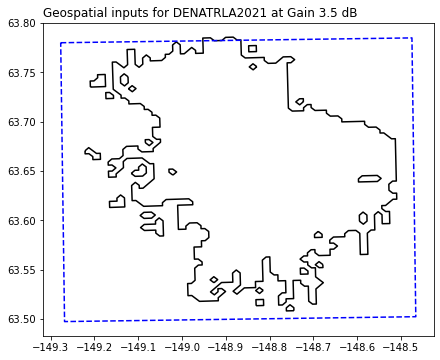

			Site layers loaded in 8.637 seconds.

		Loading and cleaning track data...


In [6]:
print("========== NPS-ActiveSpace Analysis Module ==========")
print("           v0.0.1 alpha\n\n")
print("\tAnalyzing", u+s+str(y), "fit for a Gain of", gain, "dB:")
print("\t\tLoading geospatial inputs...")
start_full = time.time()
start = time.time()

# load the active space
# matching the above parameters
active = load_activespace(u, s, y, gain, crs="epsg:4326")

# load the study area
# matching the above parameters 
studyA = load_studyarea(u, s, y, crs="epsg:4326")

if(draw_plots):
    
    # an overview of the two requisite spatial inputs 
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    studyA.boundary.plot(ax=ax, color="blue", ls="--")
    active.boundary.plot(ax=ax, color="black", zorder=1)
    ax.set_title("Geospatial inputs for " + u+s+str(y) + " at Gain " + str(gain) + " dB", loc="left")
    simple_aspect = get_aspect(ax)
    plt.show()

end = time.time()
print(f"\t\t\tSite layers loaded in {(end - start):.3f} seconds.\n")
print("\t\tLoading and cleaning track data...")
start = time.time()

# initialize the `sqlalchemy` engine
engine = sqlalchemy.create_engine('postgresql://{username}:{password}@{host}:{port}/{name}'.format(username="overflights_admin", 
                                                                                                   password="0verfl!ghts",
                                                                                                   host="165.83.50.64",
                                                                                                   port="5432",
                                                                                                   name="overflights"))
# load tracks from the database over a certain daterange, using the buffered site
tracks = query_tracks(engine=engine,
                      start_date=start_date, end_date=end_date,
                      mask=studyA)

tracks = tracks.set_crs('WGS84') # define the spatial reference manually


			Raw track data parsed in 24.055 seconds.

		Splining track data...
			Tracks splined in 6.921 seconds.

		Computing track intersections with active space...



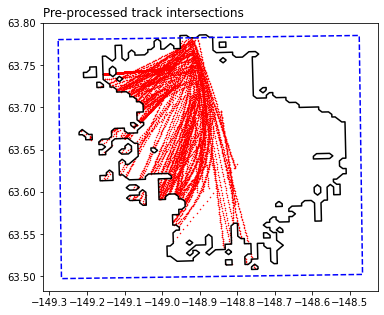

In [7]:

# ensure field names are uniform across all track sources
tracks.rename(columns={'ak_datetime': 'point_dt'}, inplace=True)
tracks.rename(columns={'geom' : 'geometry'}, inplace=True)

end = time.time()
print(f"\t\t\tRaw track data parsed in {(end - start):.3f} seconds.\n")
print("\t\tSplining track data...")
start = time.time()

# to spline, we first group by flight ID
grouped = tracks.groupby('flight_id')
result_dataframes = grouped.apply(process_group, process_func=internal_interpolate_spline)

# clean the data frame of empty rows
cleaned_df = result_dataframes.dropna()
cleaned_df = cleaned_df.reset_index()
cleaned_df = gpd.GeoDataFrame(cleaned_df) # apparently we need to coerce in some cases?

end = time.time()
print(f"\t\t\tTracks splined in {(end - start):.3f} seconds.\n")
print("\t\tComputing track intersections with active space...\n")
start = time.time()

#identify intersections
intersections = gpd.overlay(cleaned_df, active, how='intersection')
intersections = intersections.drop(columns=['level_1', 'altitude_m', 'mic_name'])
# intersections = intersections.rename(columns={'point_dt': 'DateTime'}) #              WHY?
intersections.dropna(axis=1, how='any')

if(draw_plots):
    
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    studyA.boundary.plot(ax=ax, color="blue", ls="--")
    intersections.plot(ax=ax, color="red", markersize=1, lw=0.5, zorder=-2)
    active.boundary.plot(ax=ax, color="black", zorder=1)
    ax.set_title("Pre-processed track intersections", loc="left")
    plt.show()
    
# glean the UTM zone using the active space centroid
# `geopandas` developers will helpfully warn us 
# about geographic co-ordinate systems, here
# but it's OK - we suppress the warning...
warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS.")
x_coord,y_coord = active["geometry"].centroid[0].xy 
utm_zone = coords_to_utm(lat=y_coord[0], lon=x_coord[0])

# to accurately compute distance, we need to be in an equal-area projection
intersections_ea = intersections.to_crs(utm_zone)
tracks_ea = tracks.to_crs(utm_zone)
grouped_ea = intersections_ea.groupby('flight_id')
active_ea = active.to_crs(utm_zone)


In [8]:
intersections_ea.rename(columns={'point_dt': 'DateTime'}, inplace=True)


True True

			Flight ID:  N185AR_202105251000
			Origin at 2021-05-25 10:51:55 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.056 seconds.
			Terminus at 2021-05-25 10:56:20 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.046 seconds.


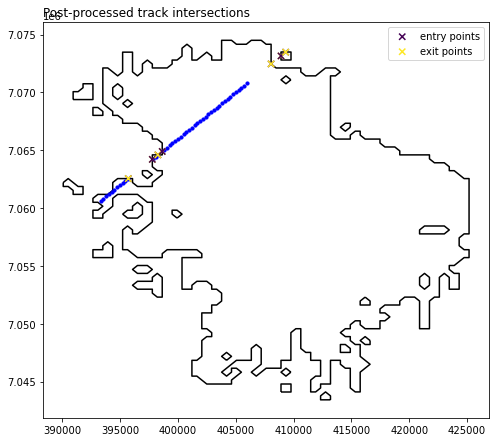

True True

			Flight ID:  N185AR_202105251700
			Origin at 2021-05-25 17:43:20 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.048 seconds.
			Terminus at 2021-05-25 17:48:20 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.049 seconds.


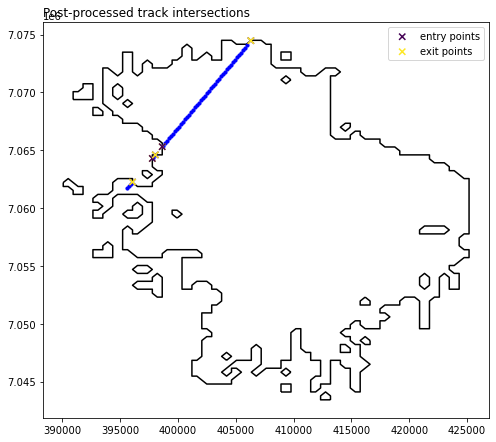

True True

			Flight ID:  N185AR_202105252015
			Origin at 2021-05-25 21:05:30 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.052 seconds.
			Terminus at 2021-05-25 21:07:50 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.046 seconds.


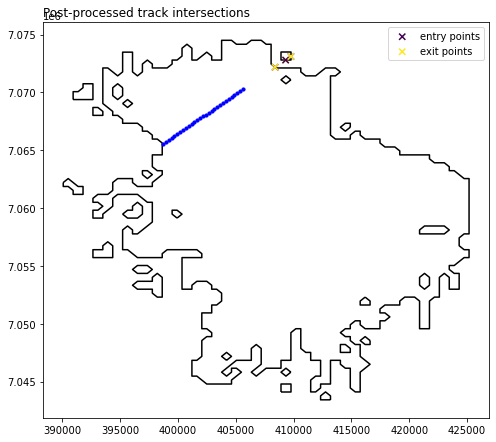

True True

			Flight ID:  N185AR_202105301815
			Origin at 2021-05-30 18:31:10 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.052 seconds.
			Terminus at 2021-05-30 18:35:55 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.048 seconds.


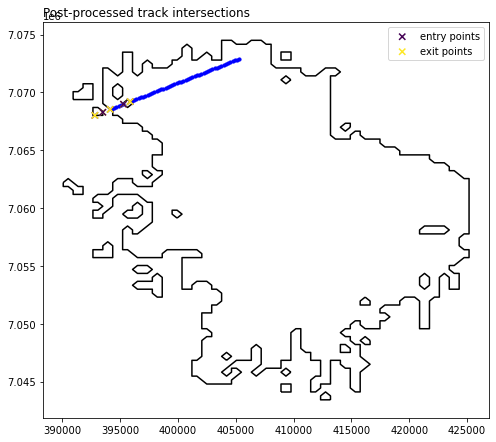

True True

			Flight ID:  N185AR_202105301945
			Origin at 2021-05-30 20:37:35 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.076 seconds.
			Terminus at 2021-05-30 20:41:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.048 seconds.


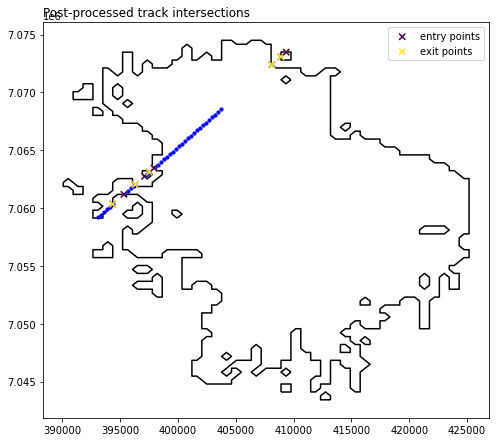

True True

			Flight ID:  N185AR_202105310830
			Origin at 2021-05-31 08:41:50 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.053 seconds.
			Terminus at 2021-05-31 08:46:50 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.044 seconds.


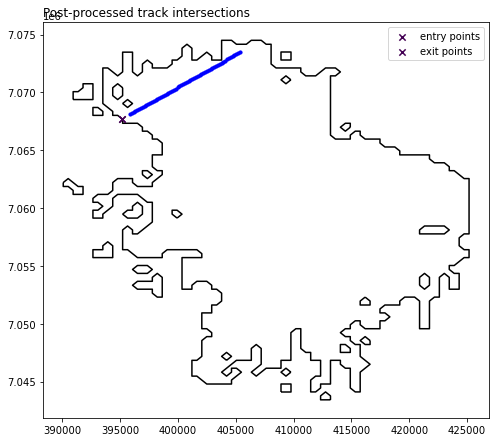

True True

			Flight ID:  N185AR_202106070830
			Origin at 2021-06-07 08:48:20 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.051 seconds.
			Terminus at 2021-06-07 08:55:30 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.049 seconds.


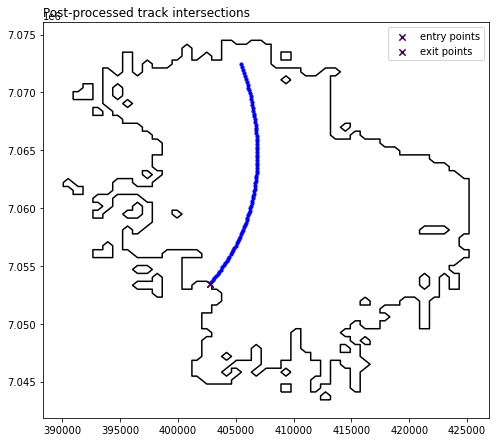

True True

			Flight ID:  N185AR_202106071015
			Origin at 2021-06-07 10:55:10 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.
			Terminus at 2021-06-07 10:59:20 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.043 seconds.


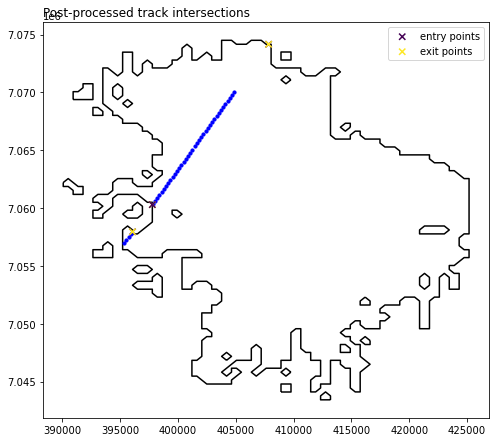

True True

			Flight ID:  N185AR_202106111515
			Origin at 2021-06-11 15:40:30 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.047 seconds.
			Terminus at 2021-06-11 15:44:05 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.


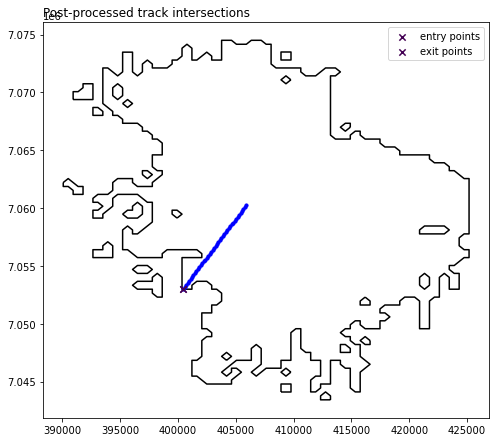

True True

			Flight ID:  N185AR_202106171515
			Origin at 2021-06-17 15:34:20 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.062 seconds.
			Terminus at 2021-06-17 15:42:50 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.


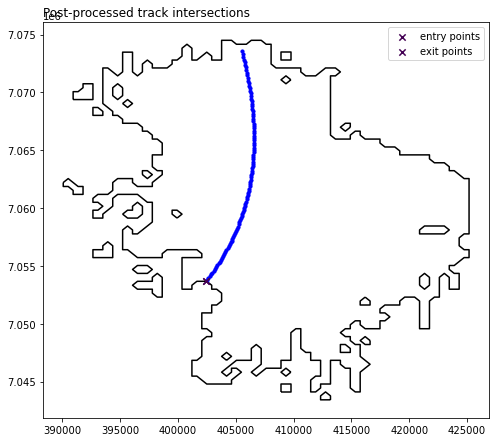

True True

			Flight ID:  N185AR_202106171700
			Origin at 2021-06-17 17:47:20 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.052 seconds.
			Terminus at 2021-06-17 17:48:30 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.045 seconds.


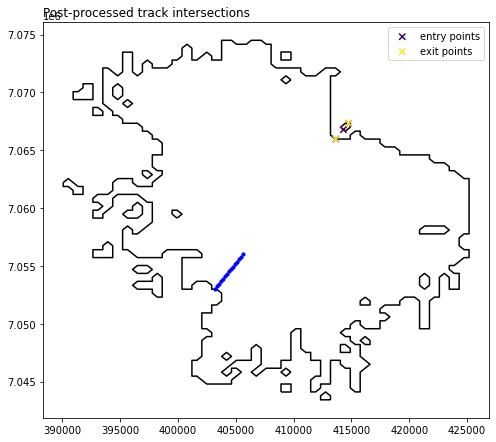

True True

			Flight ID:  N185AR_202106171830
			Origin at 2021-06-17 18:37:30 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.048 seconds.
			Terminus at 2021-06-17 18:44:50 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.053 seconds.


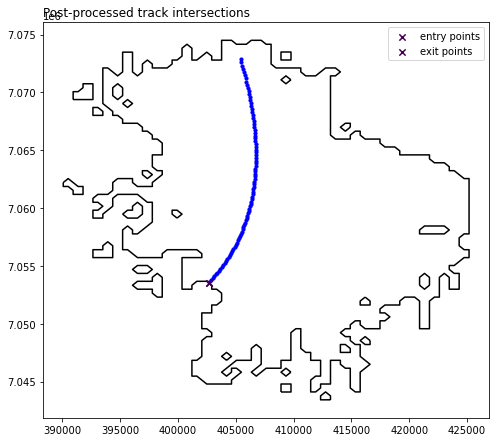

True True

			Flight ID:  N185AR_202106180945
			Origin at 2021-06-18 10:34:40 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.048 seconds.
			Terminus at 2021-06-18 10:36:30 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.065 seconds.


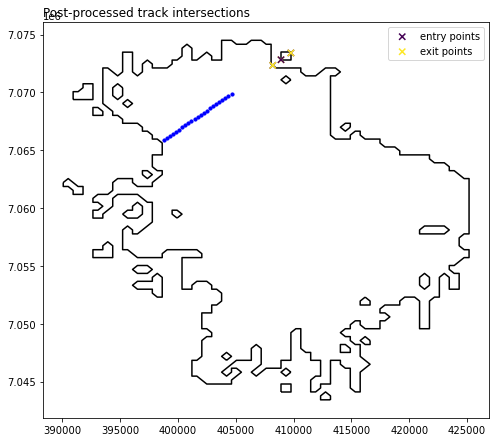

True True

			Flight ID:  N185AR_202106181930
			Origin at 2021-06-18 20:14:50 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.052 seconds.
			Terminus at 2021-06-18 20:18:30 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.051 seconds.


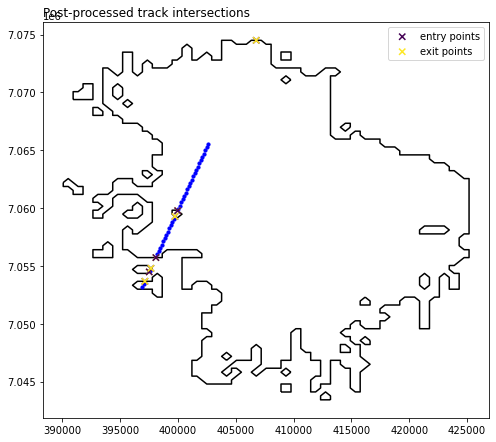

True True

			Flight ID:  N185AR_202106190830
			Origin at 2021-06-19 08:43:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.046 seconds.
			Terminus at 2021-06-19 08:47:45 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.051 seconds.


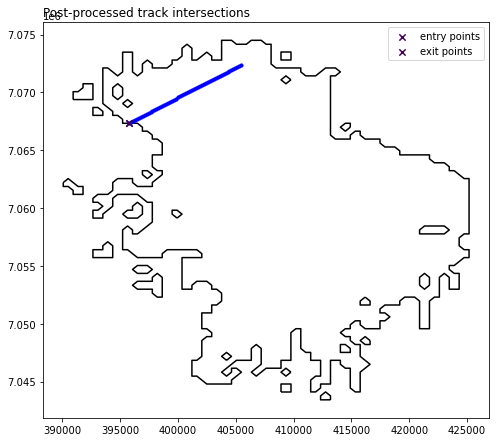

True True

			Flight ID:  N185AR_202106210830
			Origin at 2021-06-21 08:43:10 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.053 seconds.
			Terminus at 2021-06-21 08:48:05 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.


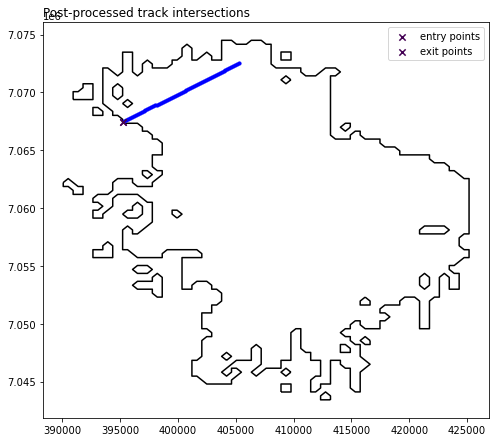

True True

			Flight ID:  N185AR_202106231200
			Origin at 2021-06-23 12:21:40 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.048 seconds.
			Terminus at 2021-06-23 12:27:40 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.043 seconds.


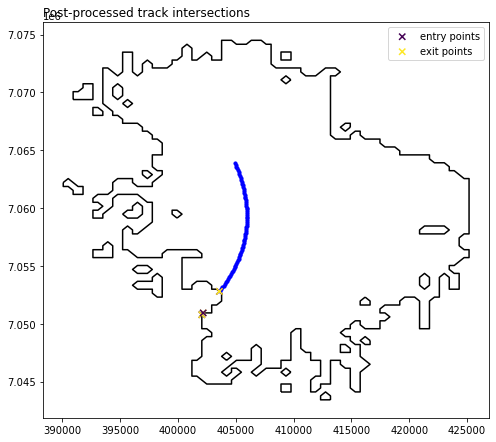

True True

			Flight ID:  N185AR_202106231345
			Origin at 2021-06-23 14:36:05 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.049 seconds.
			Terminus at 2021-06-23 14:39:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.045 seconds.


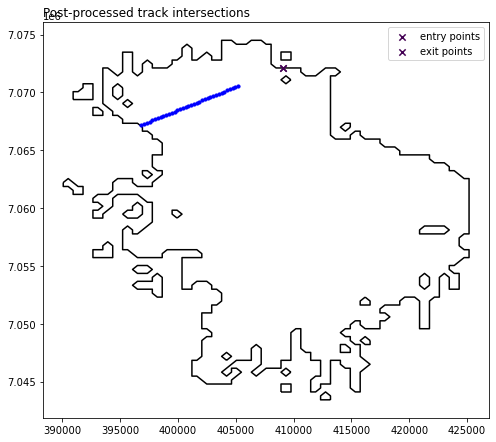

True True

			Flight ID:  N185AR_202106251530
			Origin at 2021-06-25 15:40:10 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.052 seconds.
			Terminus at 2021-06-25 17:42:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.049 seconds.


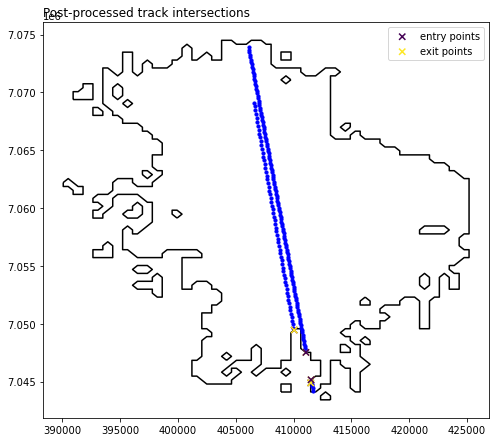

True True

			Flight ID:  N185AR_202106251900
			Origin at 2021-06-25 19:08:50 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.049 seconds.
			Terminus at 2021-06-25 21:04:10 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.047 seconds.


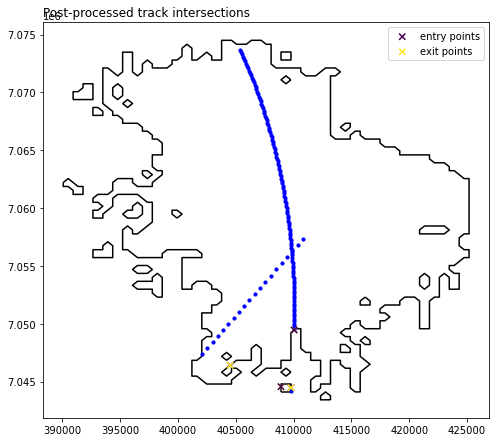

True True

			Flight ID:  N185AR_202106261515
			Origin at 2021-06-26 15:32:20 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.077 seconds.
			Terminus at 2021-06-26 15:37:10 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.046 seconds.


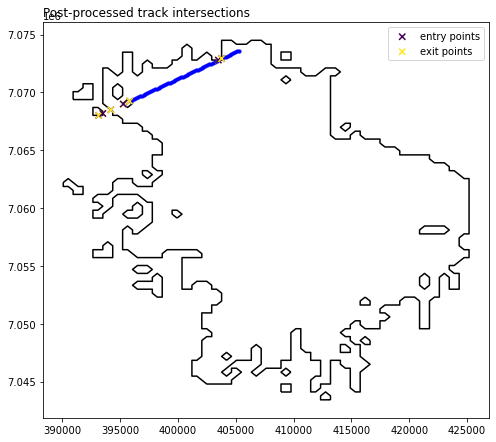

True True

			Flight ID:  N185AR_202106271815
			Origin at 2021-06-27 18:31:20 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.049 seconds.
			Terminus at 2021-06-27 18:36:20 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.044 seconds.


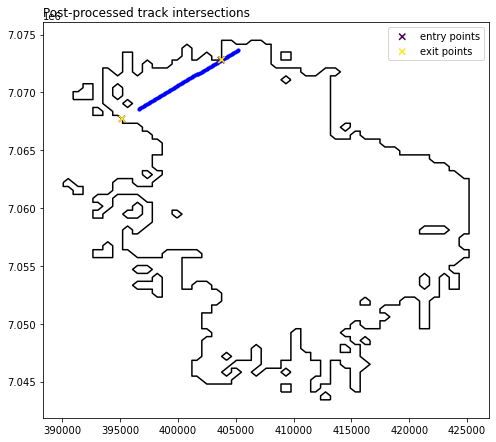

True True

			Flight ID:  N185AR_202106281515
			Origin at 2021-06-28 15:35:40 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.048 seconds.
			Terminus at 2021-06-28 15:43:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.047 seconds.


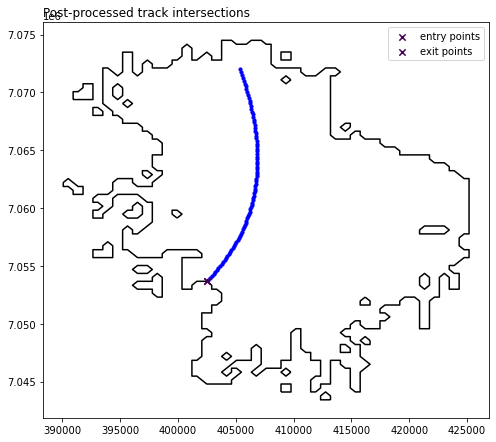

True True

			Flight ID:  N185AR_202106290830
			Origin at 2021-06-29 08:58:10 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.075 seconds.
			Terminus at 2021-06-29 09:02:15 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.051 seconds.


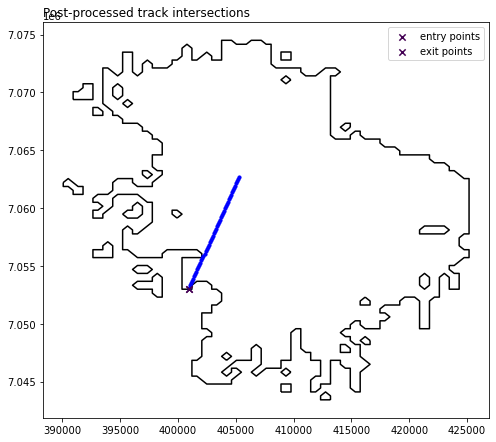

True True

			Flight ID:  N185AR_202106291015
			Origin at 2021-06-29 11:03:35 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.
			Terminus at 2021-06-29 11:06:50 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.044 seconds.


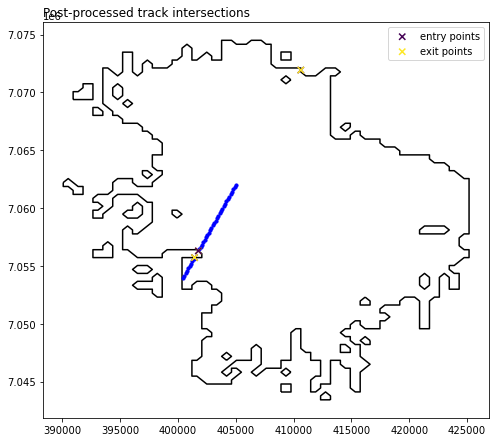

True True

			Flight ID:  N185AR_202106291815
			Origin at 2021-06-29 18:36:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.047 seconds.
			Terminus at 2021-06-29 18:39:50 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.046 seconds.


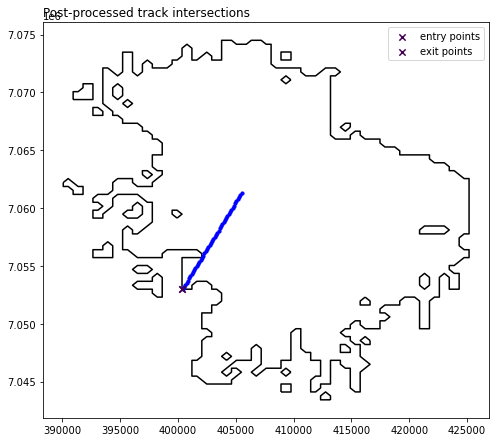

True True

			Flight ID:  N185AR_202106292000
			Origin at 2021-06-29 20:38:15 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.074 seconds.
			Terminus at 2021-06-29 20:42:20 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.054 seconds.


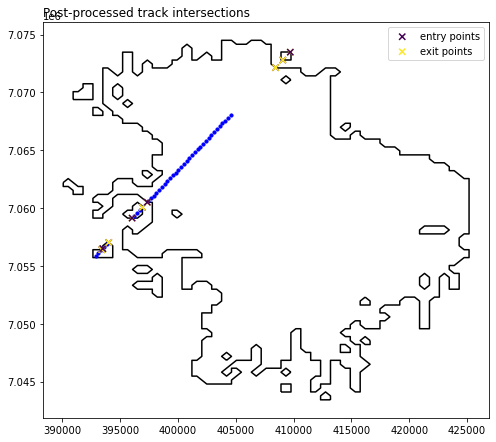

True True

			Flight ID:  N185AR_202106301815
			Origin at 2021-06-30 18:34:40 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.054 seconds.
			Terminus at 2021-06-30 18:43:25 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.047 seconds.


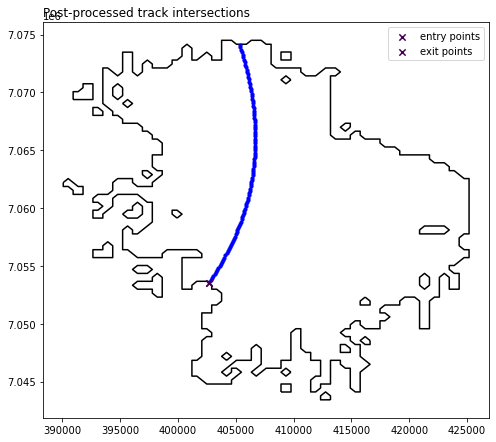

True True

			Flight ID:  N185AR_202107010745
			Origin at 2021-07-01 08:04:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.052 seconds.
			Terminus at 2021-07-01 08:09:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.047 seconds.


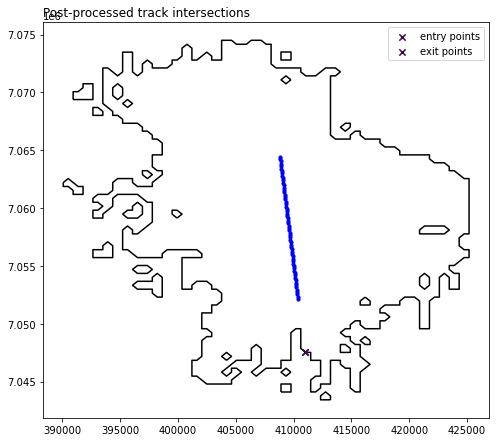

True True

			Flight ID:  N185AR_202107010845
			Origin at 2021-07-01 09:04:20 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.062 seconds.
			Terminus at 2021-07-01 09:09:20 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.049 seconds.


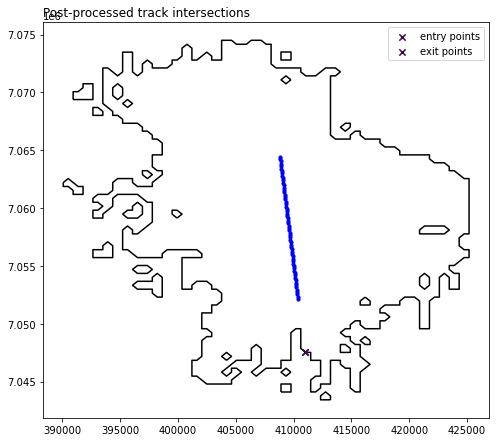

True True

			Flight ID:  N185AR_202107010930
			Origin at 2021-07-01 10:20:10 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.051 seconds.
			Terminus at 2021-07-01 10:24:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.051 seconds.


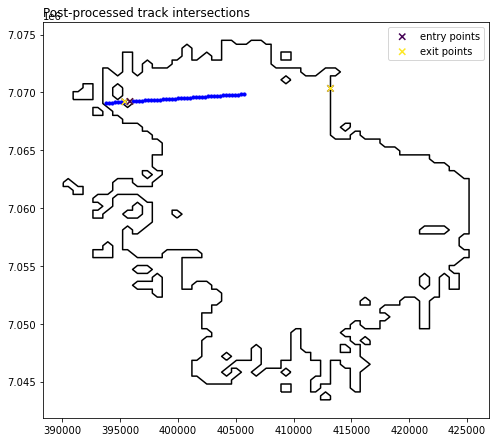

True True

			Flight ID:  N185AR_202107011030
			Origin at 2021-07-01 11:20:30 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.049 seconds.
			Terminus at 2021-07-01 11:24:20 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.044 seconds.


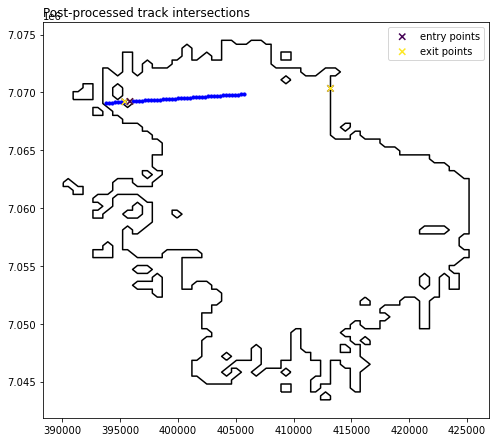

True True

			Flight ID:  N185AR_202107071715
			Origin at 2021-07-07 17:35:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.060 seconds.
			Terminus at 2021-07-07 17:41:40 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.051 seconds.


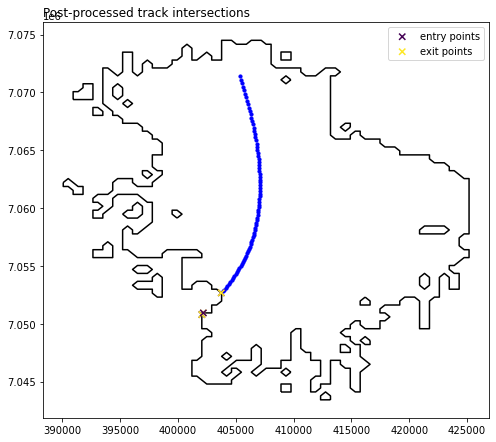

True True

			Flight ID:  N185AR_202107071815
			Origin at 2021-07-07 18:35:40 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.054 seconds.
			Terminus at 2021-07-07 18:42:20 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.


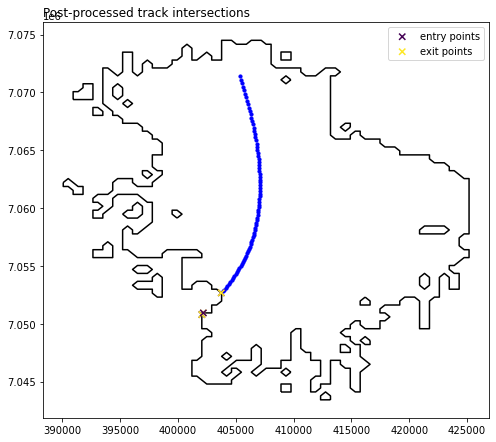

True True

			Flight ID:  N185AR_202107071900
			Origin at 2021-07-07 19:57:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.051 seconds.
			Terminus at 2021-07-07 20:01:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.048 seconds.


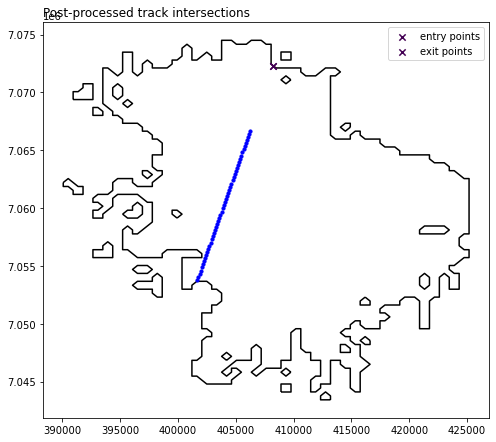

True True

			Flight ID:  N185AR_202107072000
			Origin at 2021-07-07 20:57:50 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.055 seconds.
			Terminus at 2021-07-07 21:01:50 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.043 seconds.


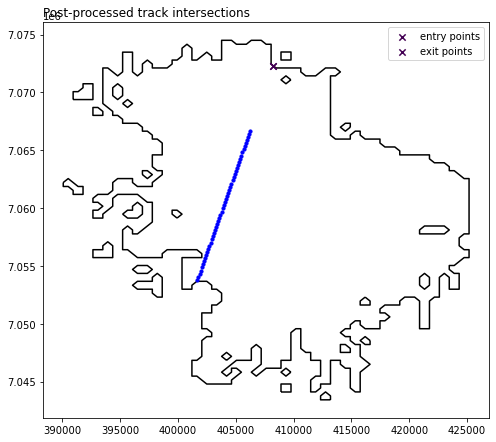

True True

			Flight ID:  N185AR_202107111715
			Origin at 2021-07-11 17:28:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.051 seconds.
			Terminus at 2021-07-11 17:33:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.048 seconds.


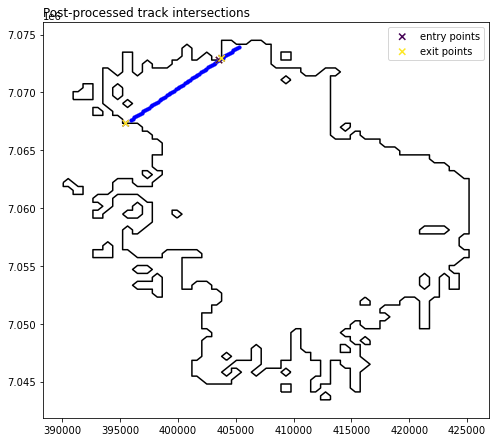

True True

			Flight ID:  N185AR_202107111815
			Origin at 2021-07-11 18:28:10 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.061 seconds.
			Terminus at 2021-07-11 18:33:10 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.046 seconds.


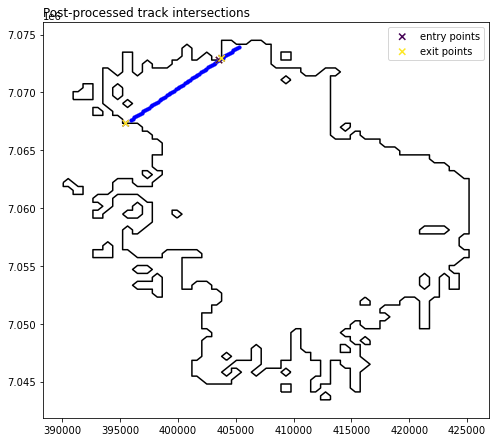

True True

			Flight ID:  N185AR_202107120730
			Origin at 2021-07-12 07:45:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.
			Terminus at 2021-07-12 07:49:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.065 seconds.


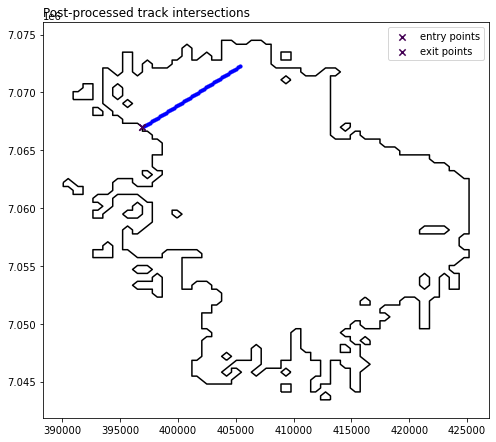

True True

			Flight ID:  N185AR_202107120830
			Origin at 2021-07-12 08:45:50 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.058 seconds.
			Terminus at 2021-07-12 08:49:50 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.045 seconds.


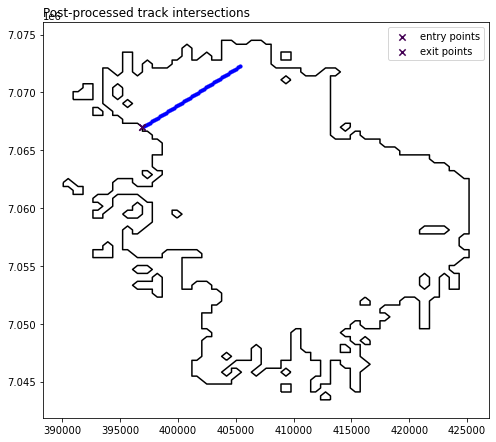

True True

			Flight ID:  N185AR_202107141100
			Origin at 2021-07-14 11:22:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.054 seconds.
			Terminus at 2021-07-14 11:29:20 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.049 seconds.


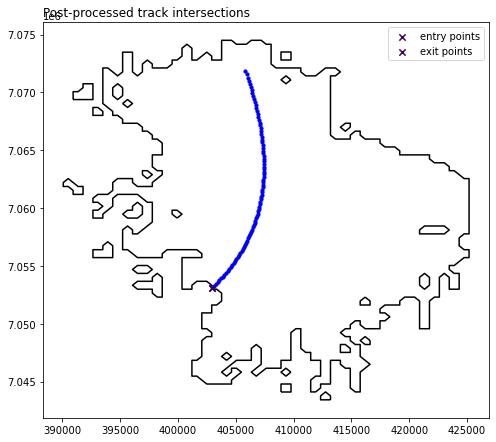

True True

			Flight ID:  N185AR_202107141200
			Origin at 2021-07-14 12:22:30 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.052 seconds.
			Terminus at 2021-07-14 12:29:50 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.051 seconds.


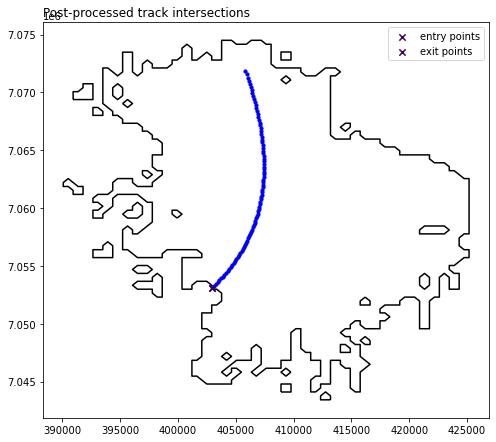

True True

			Flight ID:  N185AR_202107141230
			Origin at 2021-07-14 13:25:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.051 seconds.
			Terminus at 2021-07-14 13:30:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.051 seconds.


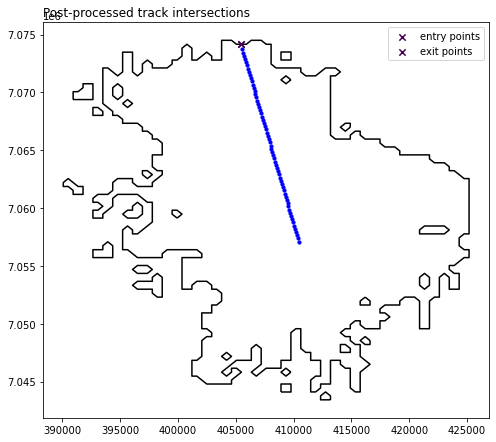

True True

			Flight ID:  N185AR_202107141330
			Origin at 2021-07-14 14:25:40 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.052 seconds.
			Terminus at 2021-07-14 14:30:40 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.049 seconds.


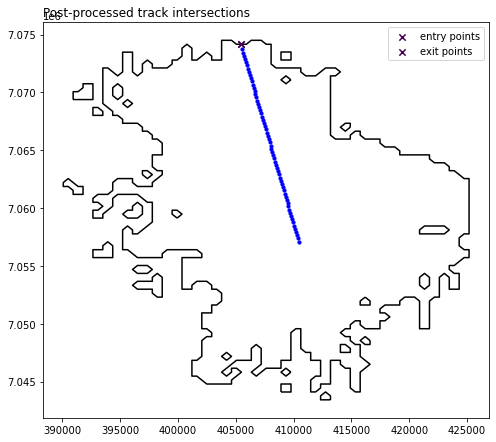

True True

			Flight ID:  N185AR_202107141415
			Origin at 2021-07-14 14:35:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.052 seconds.
			Terminus at 2021-07-14 14:40:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.


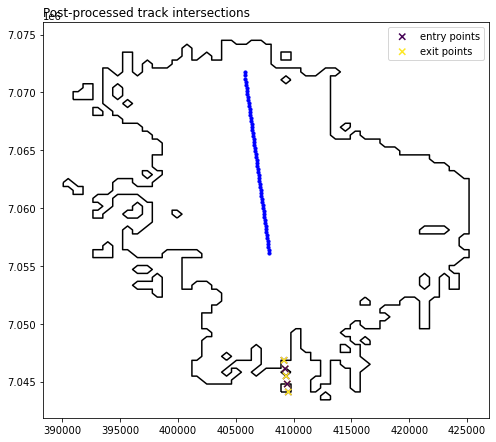

True True

			Flight ID:  N185AR_202107141515
			Origin at 2021-07-14 15:35:20 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.049 seconds.
			Terminus at 2021-07-14 15:40:20 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.


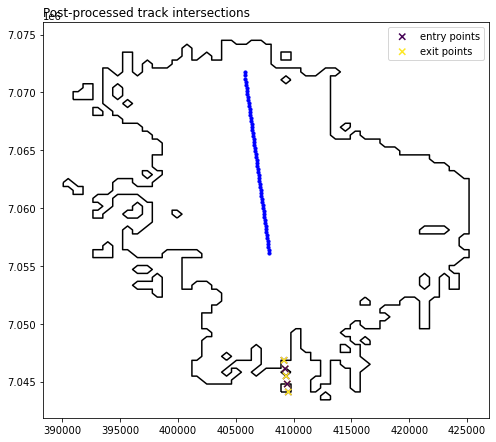

True True

			Flight ID:  N185AR_202107141600
			Origin at 2021-07-14 16:39:25 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.052 seconds.
			Terminus at 2021-07-14 16:44:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.047 seconds.


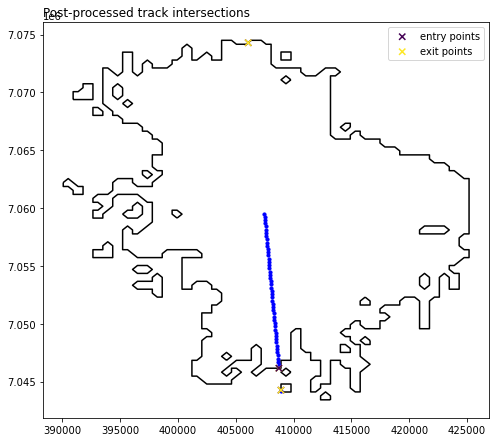

True True

			Flight ID:  N185AR_202107141700
			Origin at 2021-07-14 17:39:55 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.
			Terminus at 2021-07-14 17:44:30 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.


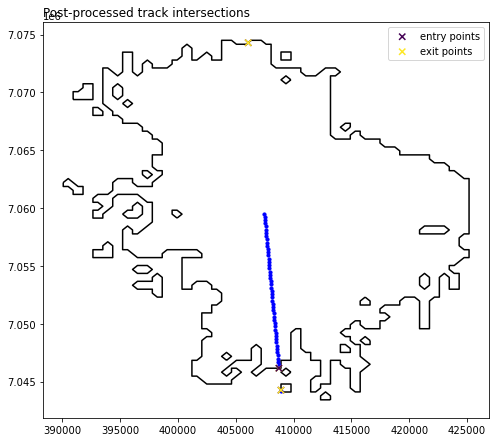

True True

			Flight ID:  N185AR_202107150730
			Origin at 2021-07-15 07:49:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.053 seconds.
			Terminus at 2021-07-15 07:56:15 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.049 seconds.


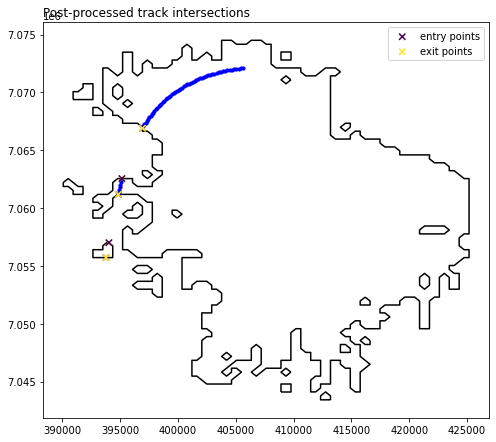

True True

			Flight ID:  N185AR_202107151100
			Origin at 2021-07-15 11:17:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.058 seconds.
			Terminus at 2021-07-15 11:24:25 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.


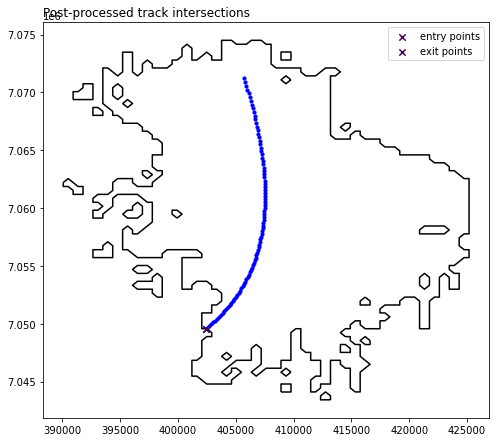

True True

			Flight ID:  N185AR_202107151230
			Origin at 2021-07-15 13:20:40 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.059 seconds.
			Terminus at 2021-07-15 13:28:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.047 seconds.


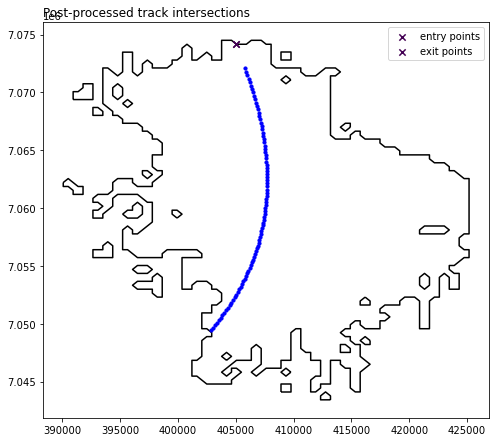

True True

			Flight ID:  N185AR_202107151400
			Origin at 2021-07-15 14:22:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.053 seconds.
			Terminus at 2021-07-15 14:28:50 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.048 seconds.


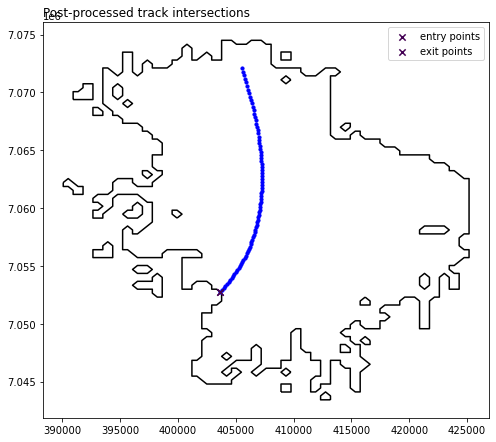

True True

			Flight ID:  N185AR_202107151715
			Origin at 2021-07-15 17:29:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.048 seconds.
			Terminus at 2021-07-15 17:31:10 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.056 seconds.


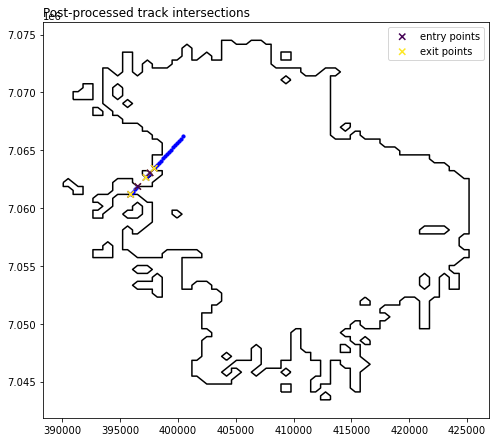

True True

			Flight ID:  N185AR_202107160730
			Origin at 2021-07-16 07:48:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.054 seconds.
			Terminus at 2021-07-16 07:53:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.046 seconds.


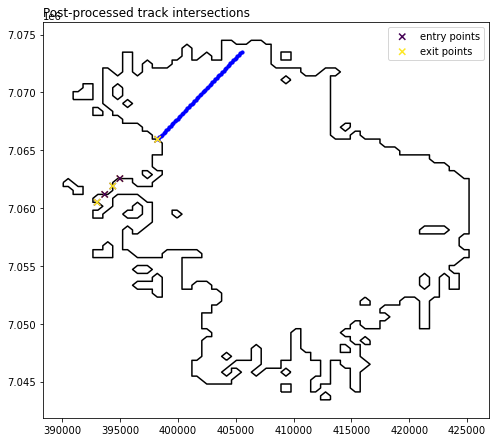

True True

			Flight ID:  N185AR_202107161415
			Origin at 2021-07-16 14:34:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.
			Terminus at 2021-07-16 14:36:50 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.053 seconds.


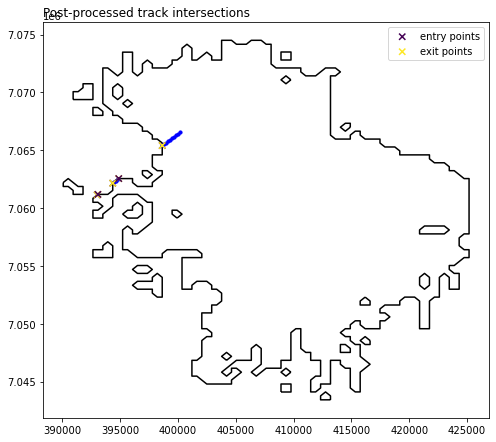

True True

			Flight ID:  N185AR_202107161730
			Origin at 2021-07-16 17:50:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.
			Terminus at 2021-07-16 17:54:40 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.


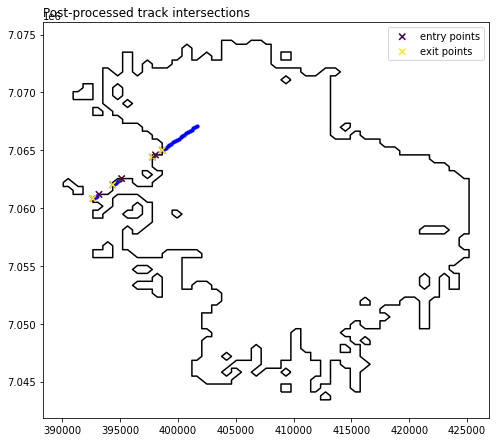

True True

			Flight ID:  N185AR_202107170730
			Origin at 2021-07-17 07:51:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.054 seconds.
			Terminus at 2021-07-17 07:54:25 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.049 seconds.


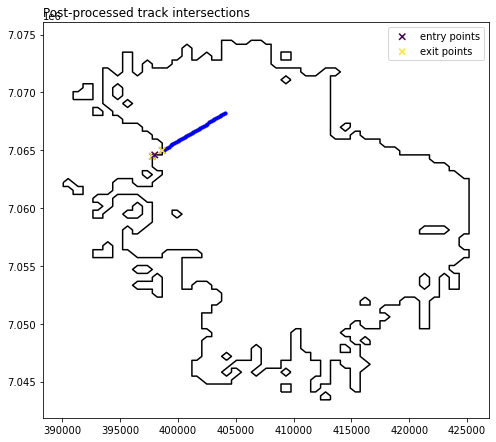

True True

			Flight ID:  N185AR_202107171100
			Origin at 2021-07-17 11:20:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.054 seconds.
			Terminus at 2021-07-17 11:20:55 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.046 seconds.


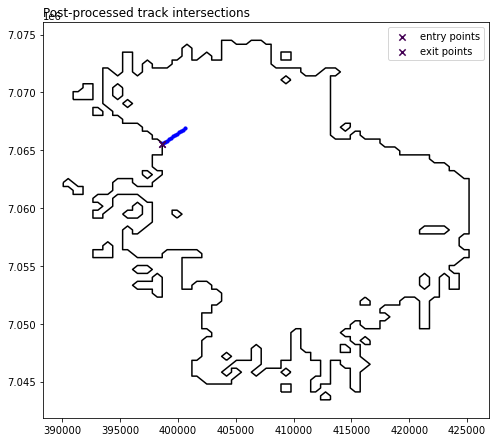

True True

			Flight ID:  N185AR_202107171245
			Origin at 2021-07-17 13:23:05 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.054 seconds.
			Terminus at 2021-07-17 13:27:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.053 seconds.


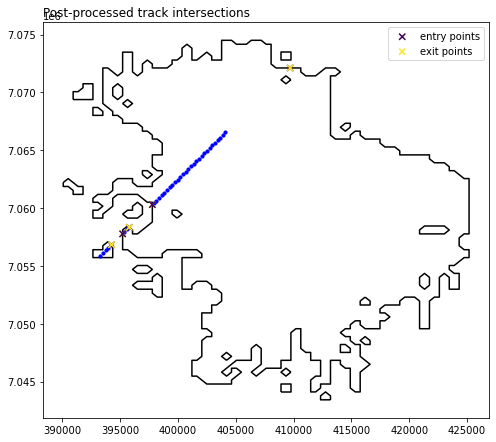

True True

			Flight ID:  N185AR_202107171715
			Origin at 2021-07-17 17:41:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.047 seconds.
			Terminus at 2021-07-17 17:42:25 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.047 seconds.


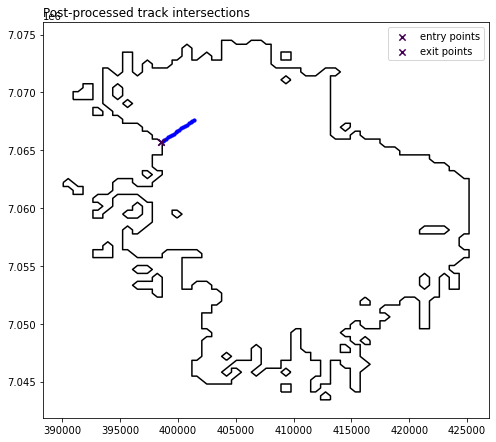

True True

			Flight ID:  N185AR_202107180730
			Origin at 2021-07-18 07:52:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.069 seconds.
			Terminus at 2021-07-18 07:56:15 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.047 seconds.


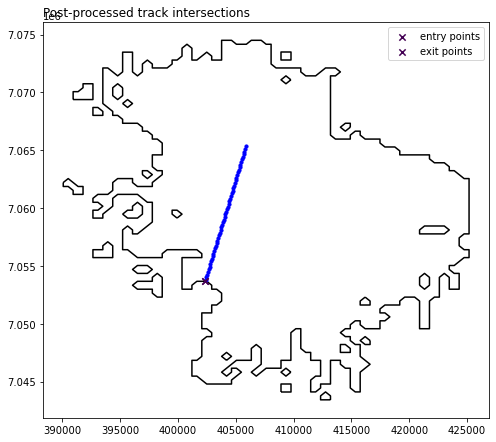

True True

			Flight ID:  N185AR_202107180900
			Origin at 2021-07-18 09:51:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.046 seconds.
			Terminus at 2021-07-18 09:56:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.048 seconds.


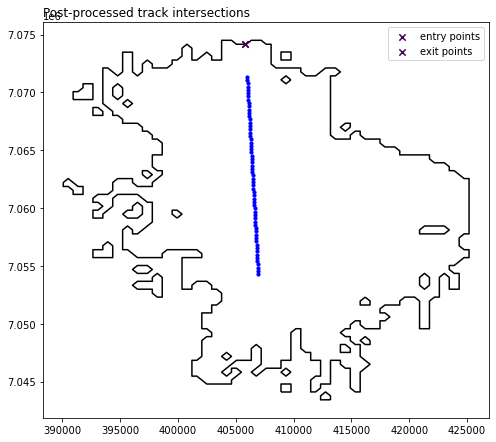

True True

			Flight ID:  N185AR_202107181115
			Origin at 2021-07-18 11:38:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.076 seconds.
			Terminus at 2021-07-18 11:41:45 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.048 seconds.


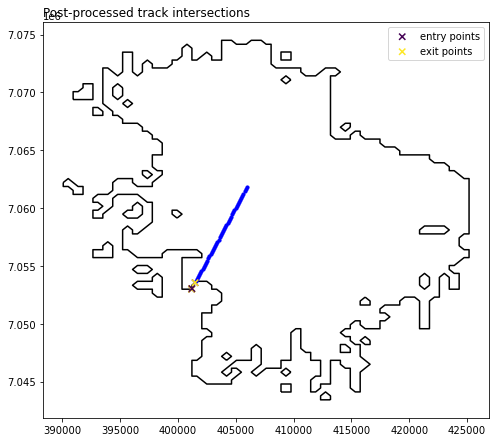

True True

			Flight ID:  N185AR_202107181415
			Origin at 2021-07-18 14:36:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.047 seconds.
			Terminus at 2021-07-18 14:40:30 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.049 seconds.


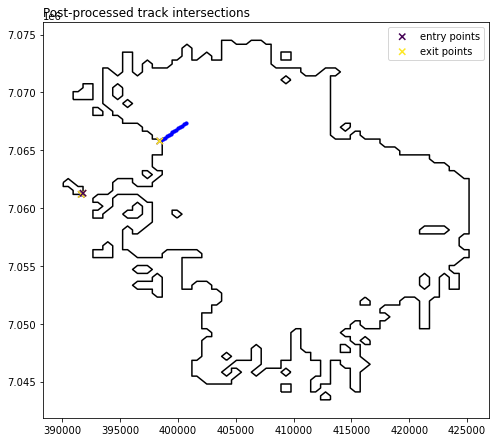

True True

			Flight ID:  N185AR_202107181715
			Origin at 2021-07-18 17:36:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.058 seconds.
			Terminus at 2021-07-18 17:37:25 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.047 seconds.


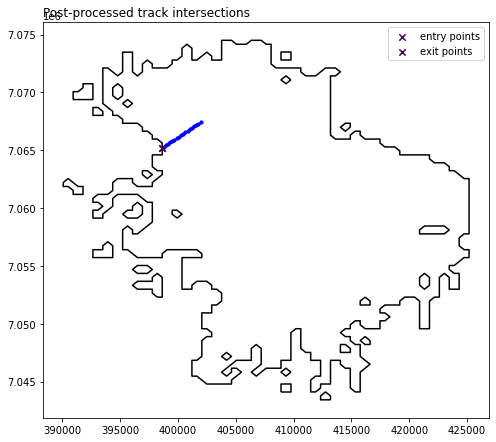

True True

			Flight ID:  N185AR_202107181900
			Origin at 2021-07-18 19:45:40 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.072 seconds.
			Terminus at 2021-07-18 19:48:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.054 seconds.


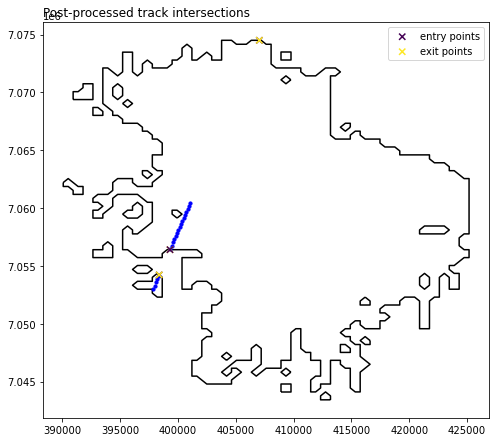

True True

			Flight ID:  N185AR_202107191715
			Origin at 2021-07-19 17:35:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.053 seconds.
			Terminus at 2021-07-19 17:44:05 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.


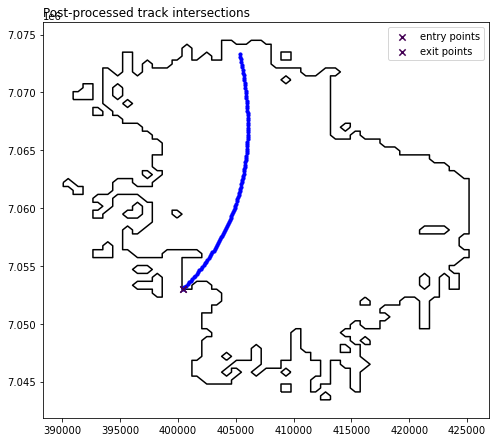

True True

			Flight ID:  N185AR_202107211715
			Origin at 2021-07-21 17:34:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.085 seconds.
			Terminus at 2021-07-21 17:39:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.053 seconds.


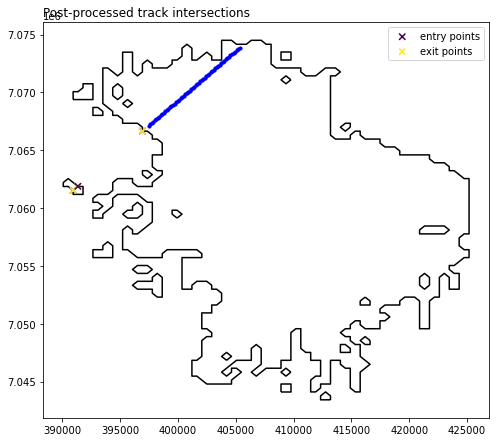

True True

			Flight ID:  N185AR_202107221415
			Origin at 2021-07-22 14:34:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.049 seconds.
			Terminus at 2021-07-22 14:38:15 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.046 seconds.


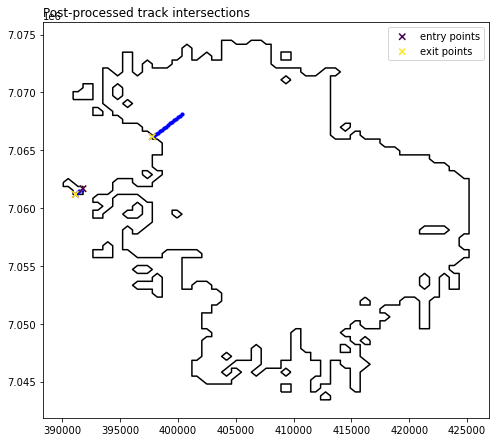

True True

			Flight ID:  N185AR_202107221545
			Origin at 2021-07-22 16:29:25 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.065 seconds.
			Terminus at 2021-07-22 16:36:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.054 seconds.


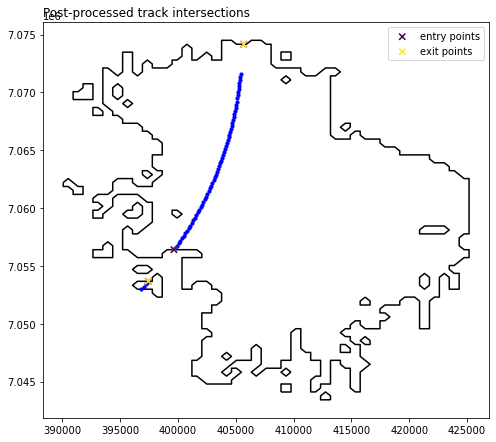

True True

			Flight ID:  N185AR_202107221715
			Origin at 2021-07-22 17:29:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.063 seconds.
			Terminus at 2021-07-22 17:36:30 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.057 seconds.


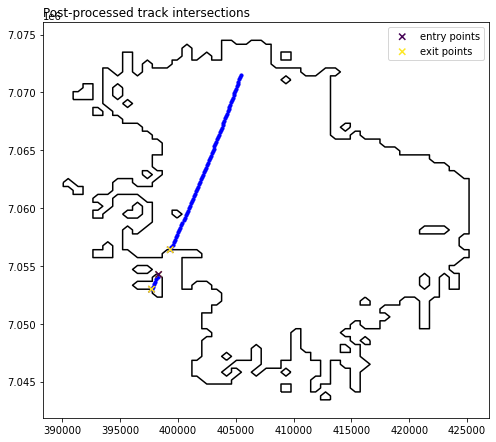

True True

			Flight ID:  N185AR_202107221845
			Origin at 2021-07-22 19:33:15 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.054 seconds.
			Terminus at 2021-07-22 19:35:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.


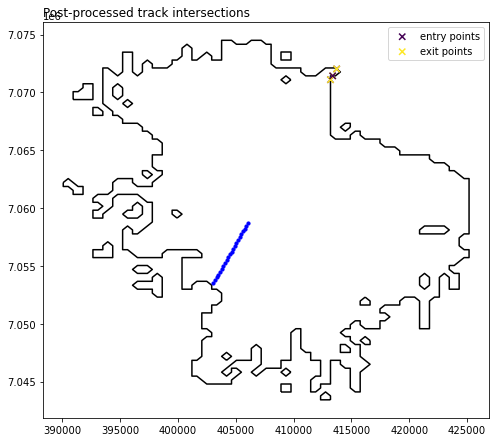

True True

			Flight ID:  N185AR_202107260730
			Origin at 2021-07-26 07:44:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.054 seconds.
			Terminus at 2021-07-26 07:53:10 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.052 seconds.


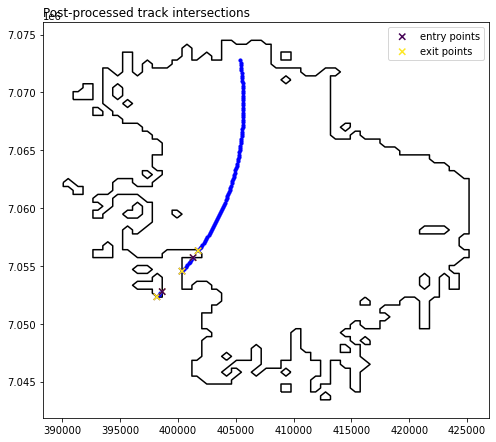

True True

			Flight ID:  N185AR_202107301730
			Origin at 2021-07-30 17:46:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.059 seconds.
			Terminus at 2021-07-30 17:47:25 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.051 seconds.


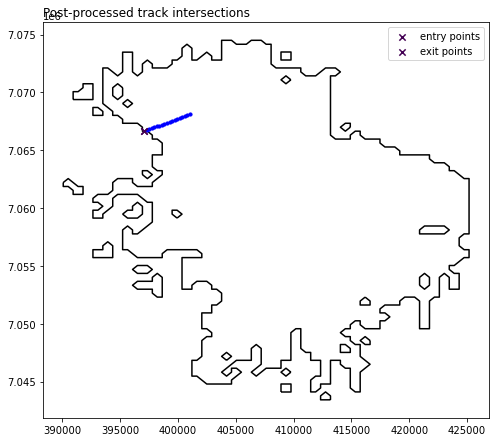

True True

			Flight ID:  N907KW_202105230915
			Origin at 2021-05-23 09:37:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.058 seconds.
			Terminus at 2021-05-23 09:40:30 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.052 seconds.


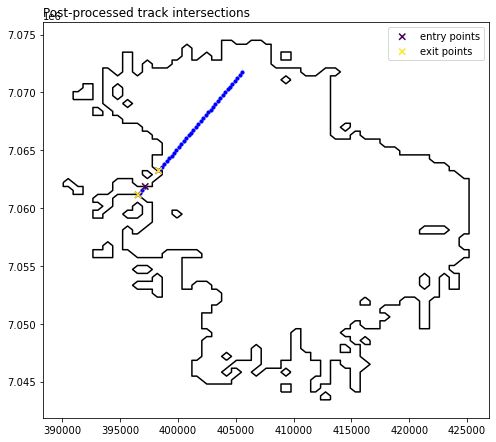

True True

			Flight ID:  N907KW_202105301215
			Origin at 2021-05-30 12:25:50 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.054 seconds.
			Terminus at 2021-05-30 12:31:15 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.


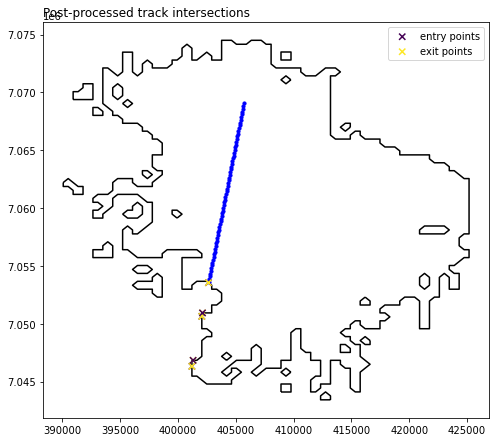

True True

			Flight ID:  N907KW_202105301345
			Origin at 2021-05-30 14:28:50 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.065 seconds.
			Terminus at 2021-05-30 14:31:10 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.


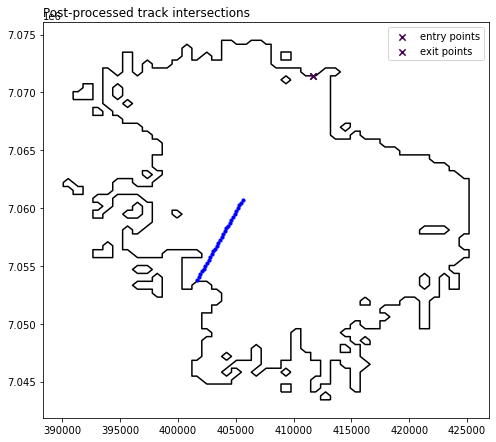

True True

			Flight ID:  N907KW_202106021945
			Origin at 2021-06-02 20:28:45 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.051 seconds.
			Terminus at 2021-06-02 20:31:50 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.053 seconds.


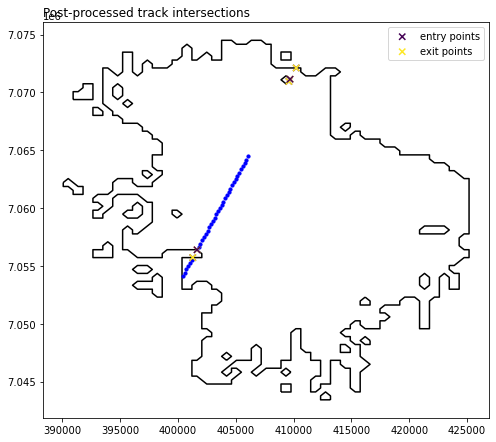

True True

			Flight ID:  N907KW_202106031400
			Origin at 2021-06-03 14:33:30 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.051 seconds.
			Terminus at 2021-06-03 14:38:40 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.045 seconds.


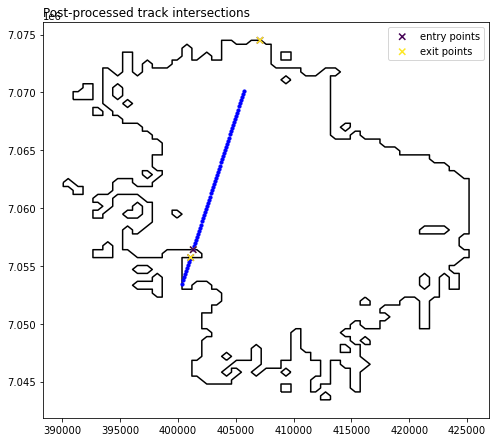

True True

			Flight ID:  N907KW_202106041530
			Origin at 2021-06-04 15:41:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.059 seconds.
			Terminus at 2021-06-04 15:43:25 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.049 seconds.


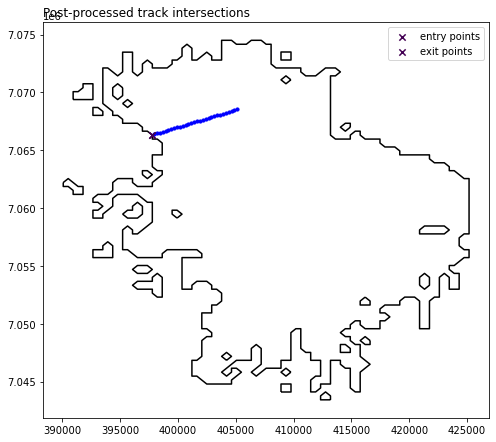

True True

			Flight ID:  N907KW_202106051000
			Origin at 2021-06-05 10:50:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.054 seconds.
			Terminus at 2021-06-05 10:56:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.056 seconds.


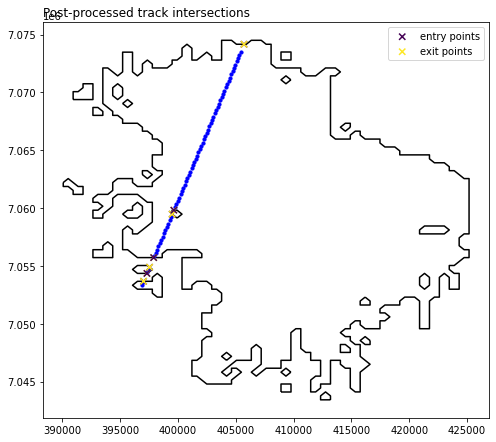

True True

			Flight ID:  N907KW_202106051800
			Origin at 2021-06-05 18:22:40 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.
			Terminus at 2021-06-05 18:28:30 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.047 seconds.


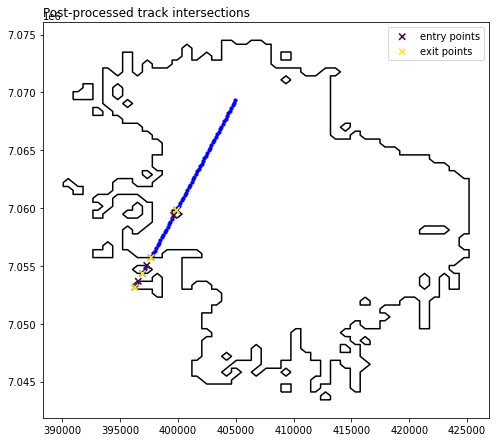

True True

			Flight ID:  N907KW_202106100830
			Origin at 2021-06-10 08:50:10 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.083 seconds.
			Terminus at 2021-06-10 08:54:15 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.058 seconds.


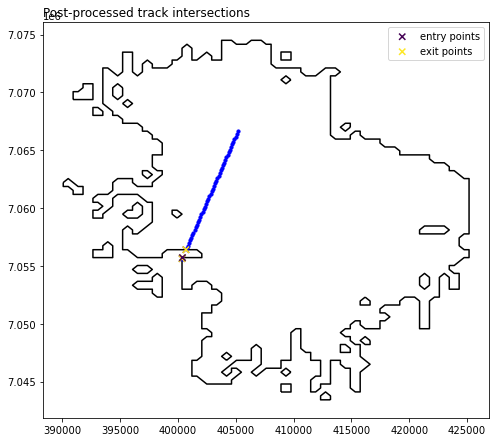

True True

			Flight ID:  N907KW_202106110830
			Origin at 2021-06-11 08:42:20 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.050 seconds.
			Terminus at 2021-06-11 08:45:35 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.053 seconds.


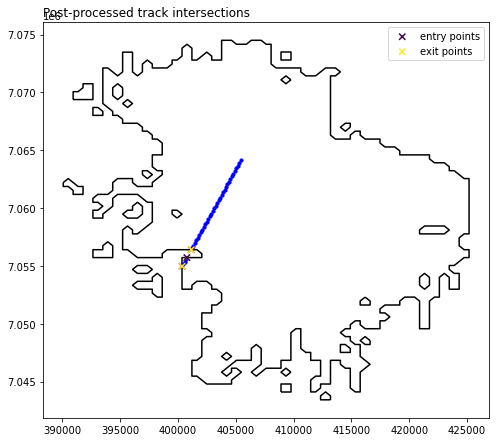

True True

			Flight ID:  N907KW_202106111000
			Origin at 2021-06-11 10:37:45 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.049 seconds.
			Terminus at 2021-06-11 10:42:40 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.046 seconds.


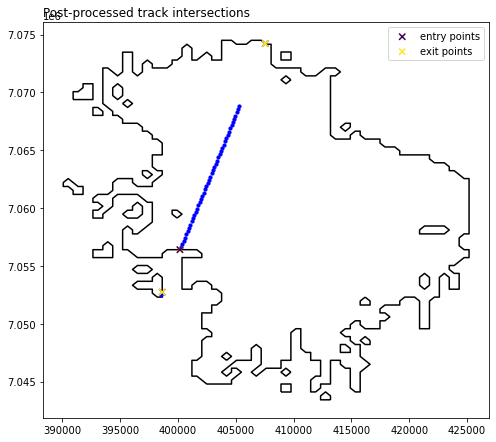

True True

			Flight ID:  N907KW_202106111200
			Origin at 2021-06-11 12:13:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.076 seconds.
			Terminus at 2021-06-11 12:18:15 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.054 seconds.


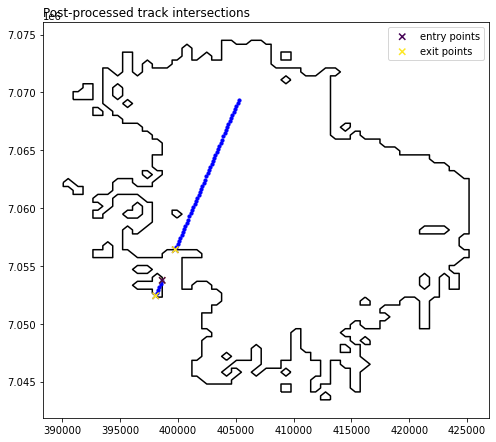

True True

			Flight ID:  N907KW_202106121030
			Origin at 2021-06-12 11:11:20 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.052 seconds.
			Terminus at 2021-06-12 11:16:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.053 seconds.


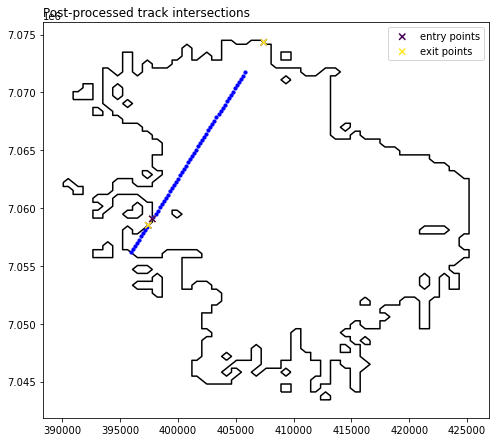

True True

			Flight ID:  N907KW_202106121330
			Origin at 2021-06-12 14:16:30 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.064 seconds.
			Terminus at 2021-06-12 14:19:50 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.054 seconds.


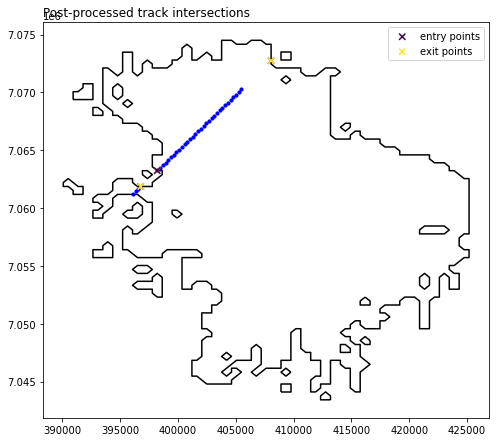

True True

			Flight ID:  N907KW_202106131630
			Origin at 2021-06-13 17:16:20 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.078 seconds.
			Terminus at 2021-06-13 17:20:30 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.069 seconds.


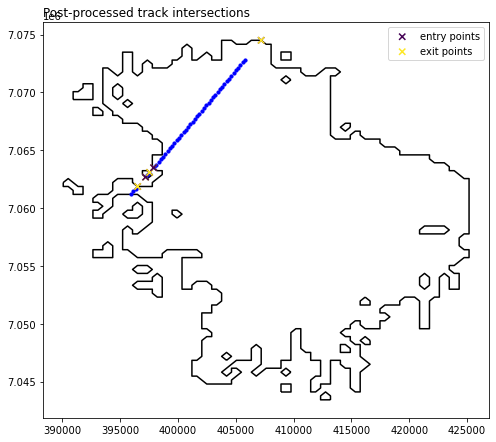

True True

			Flight ID:  N907KW_202106132015
			Origin at 2021-06-13 20:54:15 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.064 seconds.
			Terminus at 2021-06-13 20:59:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.054 seconds.


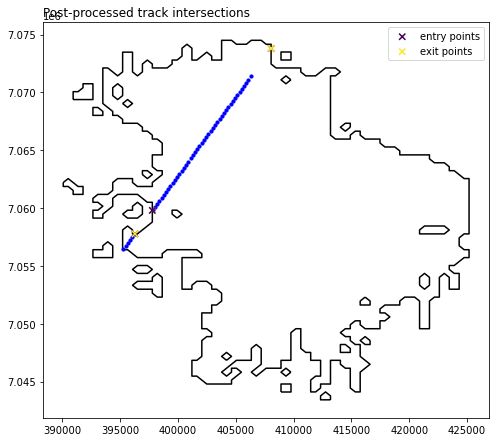

True True

			Flight ID:  N907KW_202106141515
			Origin at 2021-06-14 15:34:20 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.057 seconds.
			Terminus at 2021-06-14 15:37:25 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.056 seconds.


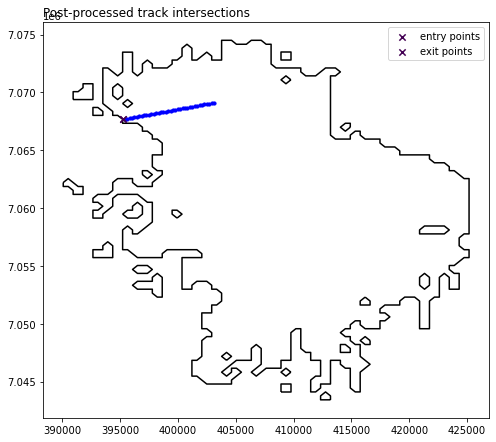

True True

			Flight ID:  N907KW_202106151700
			Origin at 2021-06-15 17:33:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.110 seconds.
			Terminus at 2021-06-15 17:38:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.060 seconds.


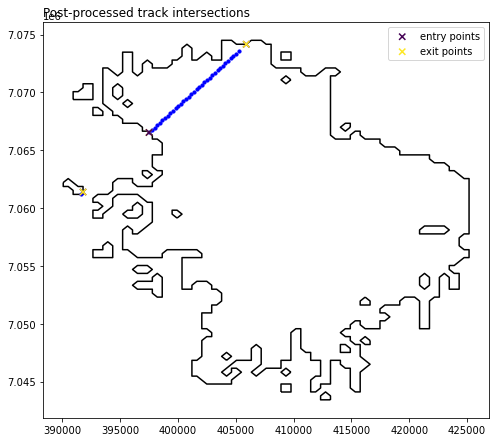

True True

			Flight ID:  N907KW_202106161200
			Origin at 2021-06-16 12:12:10 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.079 seconds.
			Terminus at 2021-06-16 13:04:05 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.066 seconds.


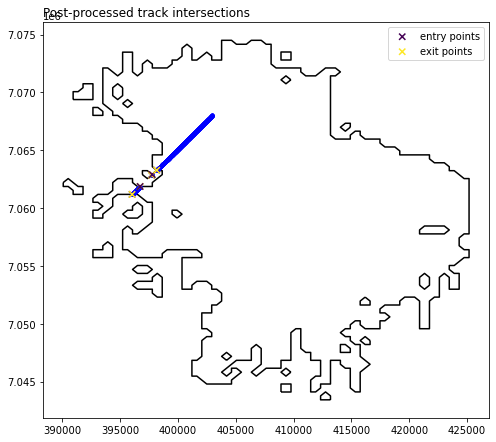

True True

			Flight ID:  N907KW_202106171515
			Origin at 2021-06-17 15:37:20 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.061 seconds.
			Terminus at 2021-06-17 15:43:15 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.060 seconds.


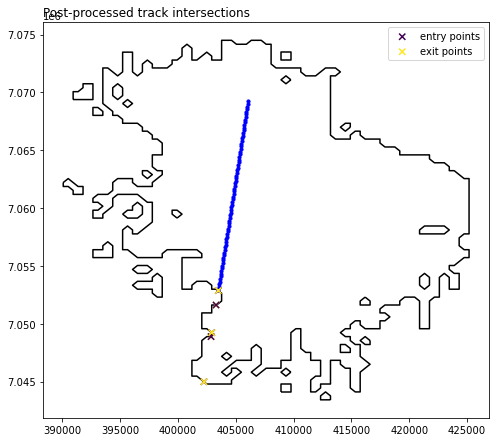

True True

			Flight ID:  N907KW_202106171700
			Origin at 2021-06-17 17:48:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.077 seconds.
			Terminus at 2021-06-17 17:51:10 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.067 seconds.


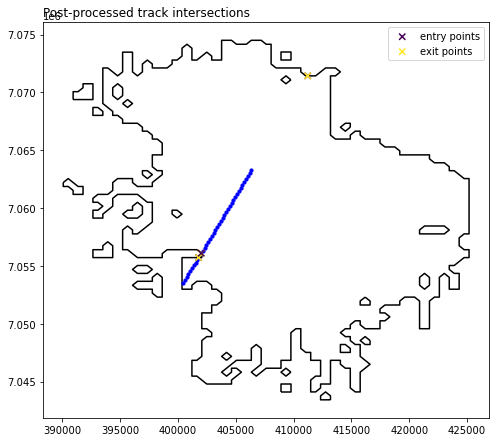

True True

			Flight ID:  N907KW_202106171830
			Origin at 2021-06-17 18:40:30 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.063 seconds.
			Terminus at 2021-06-17 18:45:35 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.060 seconds.


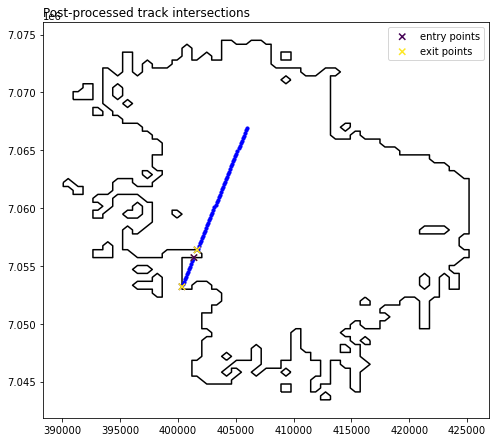

True True

			Flight ID:  N907KW_202106201215
			Origin at 2021-06-20 12:25:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.077 seconds.
			Terminus at 2021-06-20 12:28:10 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.056 seconds.


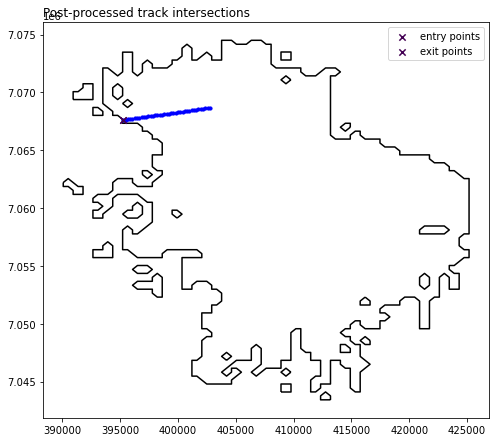

True True

			Flight ID:  N907KW_202106231200
			Origin at 2021-06-23 12:19:10 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.081 seconds.
			Terminus at 2021-06-23 12:27:50 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.077 seconds.


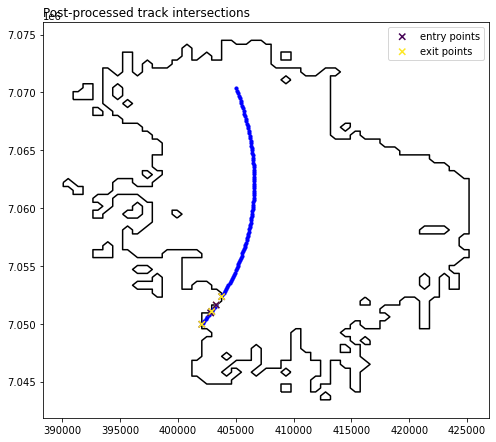

True True

			Flight ID:  N907KW_202106231345
			Origin at 2021-06-23 14:31:45 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.064 seconds.
			Terminus at 2021-06-23 14:35:40 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.061 seconds.


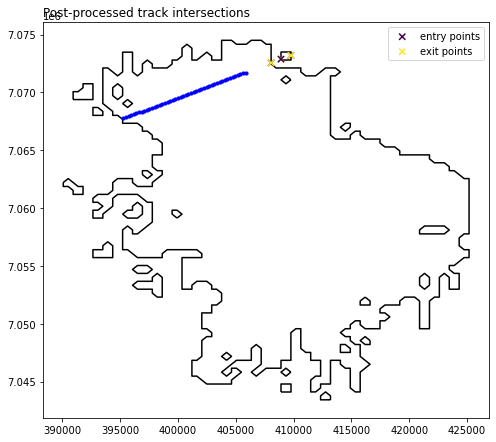

True True

			Flight ID:  N907KW_202106251530
			Origin at 2021-06-25 15:42:20 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.066 seconds.
			Terminus at 2021-06-25 17:39:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.071 seconds.


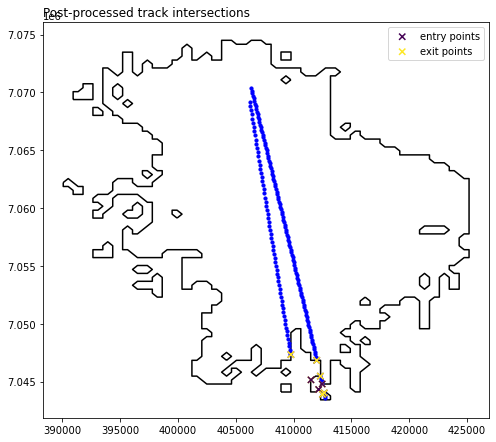

True True

			Flight ID:  N907KW_202106251900
			Origin at 2021-06-25 19:10:50 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.085 seconds.
			Terminus at 2021-06-25 19:16:50 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.067 seconds.


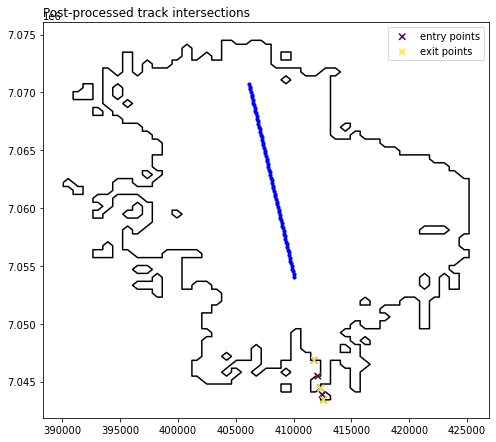

True True

			Flight ID:  N907KW_202106261515
			Origin at 2021-06-26 15:34:40 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.067 seconds.
			Terminus at 2021-06-26 15:37:15 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.062 seconds.


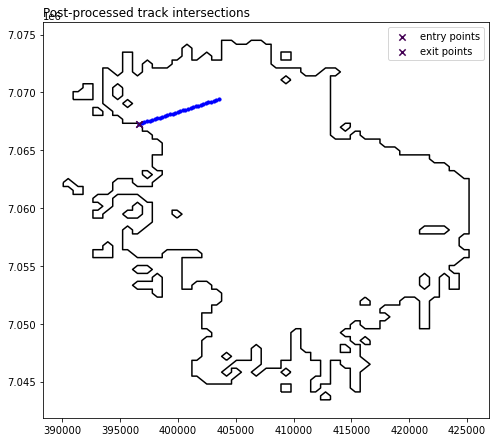

True True

			Flight ID:  N907KW_202106261830
			Origin at 2021-06-26 18:47:10 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.094 seconds.
			Terminus at 2021-06-26 18:52:05 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.059 seconds.


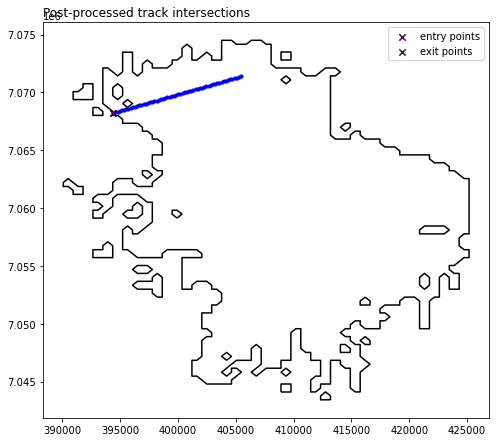

True True

			Flight ID:  N907KW_202106271815
			Origin at 2021-06-27 18:33:10 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.087 seconds.
			Terminus at 2021-06-27 18:37:10 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.062 seconds.


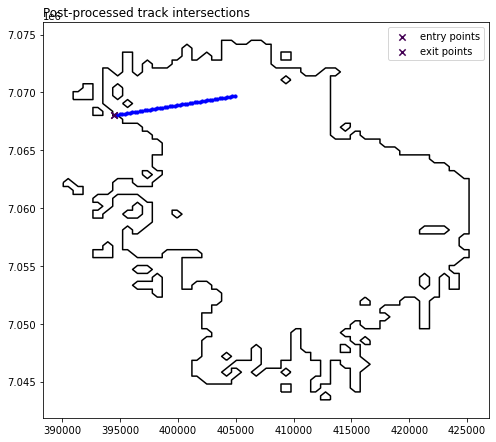

True True

			Flight ID:  N907KW_202106281515
			Origin at 2021-06-28 15:37:50 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.087 seconds.
			Terminus at 2021-06-28 15:43:20 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.075 seconds.


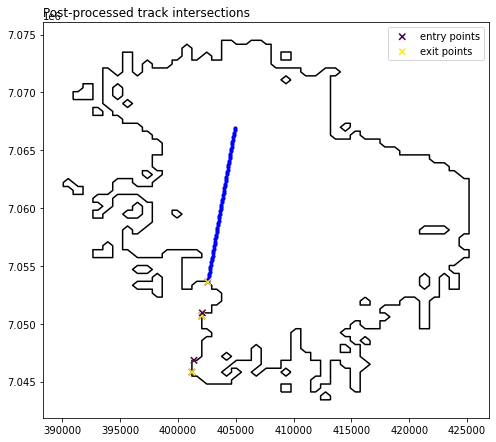

True True

			Flight ID:  N907KW_202106290845
			Origin at 2021-06-29 08:55:10 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.090 seconds.
			Terminus at 2021-06-29 09:01:10 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.066 seconds.


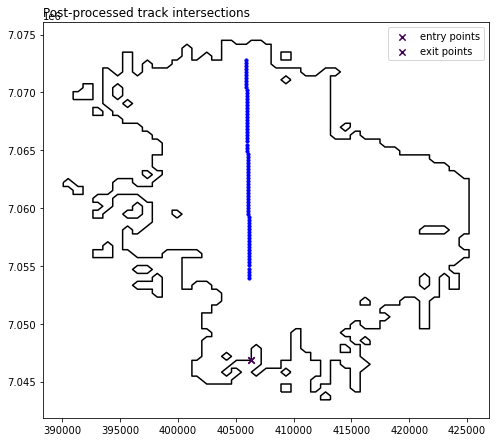

True True

			Flight ID:  N907KW_202106291015
			Origin at 2021-06-29 10:59:15 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.139 seconds.
			Terminus at 2021-06-29 11:04:20 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.084 seconds.


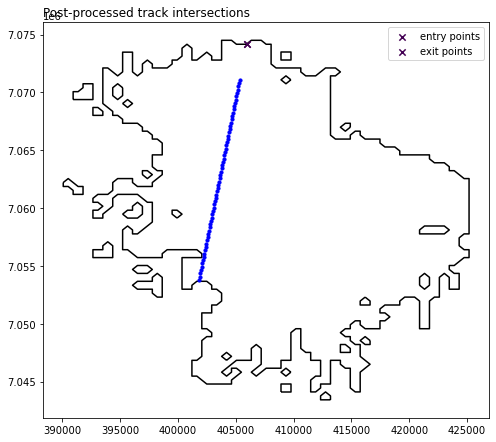

True True

			Flight ID:  N907KW_202106291815
			Origin at 2021-06-29 18:33:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.097 seconds.
			Terminus at 2021-06-29 18:39:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.098 seconds.


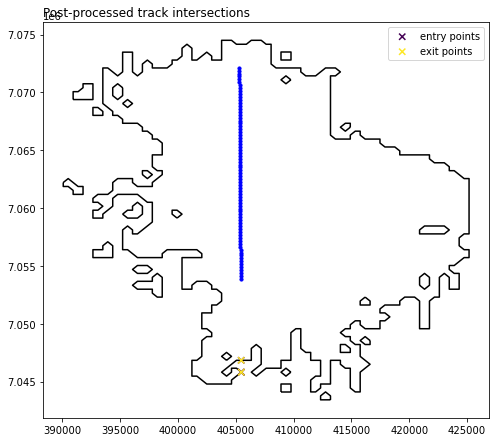

True True

			Flight ID:  N907KW_202106301815
			Origin at 2021-06-30 18:36:40 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.064 seconds.
			Terminus at 2021-06-30 18:45:05 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.065 seconds.


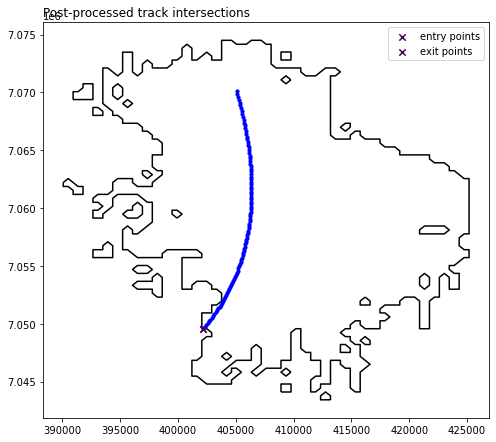

True True

			Flight ID:  N907KW_202107010845
			Origin at 2021-07-01 09:02:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.087 seconds.
			Terminus at 2021-07-01 09:08:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.069 seconds.


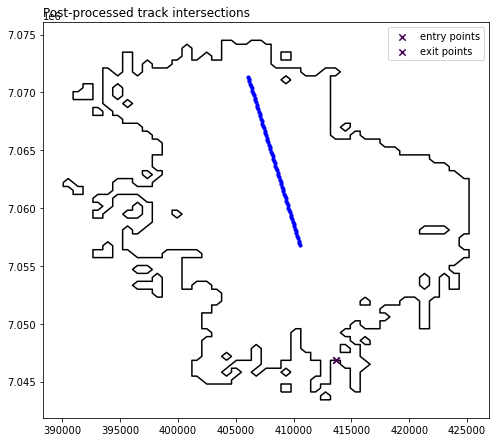

True True

			Flight ID:  N907KW_202107021200
			Origin at 2021-07-02 12:18:30 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.073 seconds.
			Terminus at 2021-07-02 12:24:10 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.079 seconds.


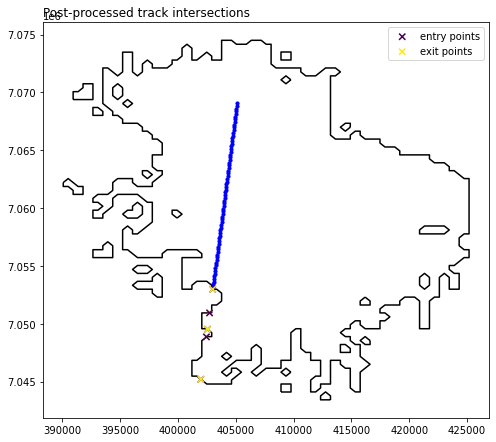

True True

			Flight ID:  N907KW_202107021330
			Origin at 2021-07-02 14:04:25 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.066 seconds.
			Terminus at 2021-07-02 14:06:50 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.065 seconds.


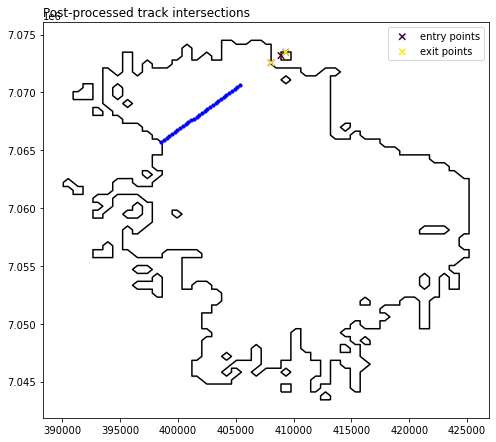

True True

			Flight ID:  N907KW_202107021815
			Origin at 2021-07-02 18:37:40 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.084 seconds.
			Terminus at 2021-07-02 20:08:15 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.080 seconds.


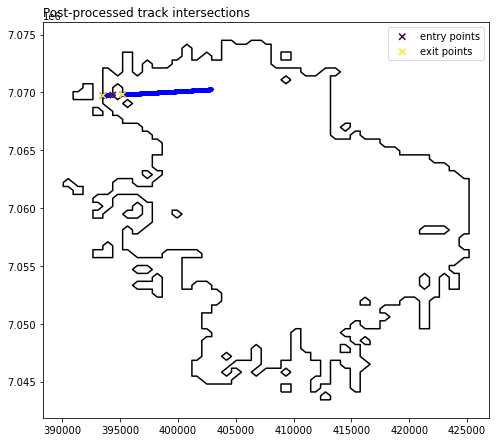

True True

			Flight ID:  N907KW_202107071815
			Origin at 2021-07-07 18:38:10 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.076 seconds.
			Terminus at 2021-07-07 18:43:20 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.067 seconds.


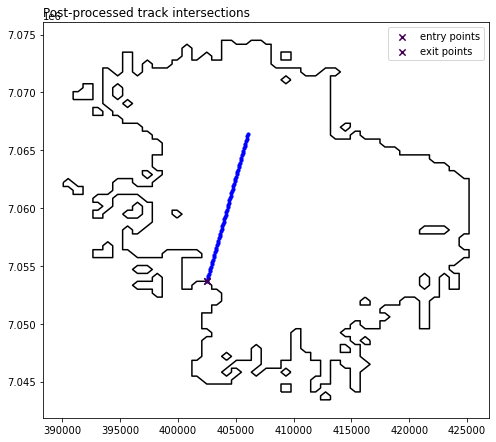

True True

			Flight ID:  N907KW_202107101515
			Origin at 2021-07-10 15:33:30 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.089 seconds.
			Terminus at 2021-07-10 15:37:25 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.068 seconds.


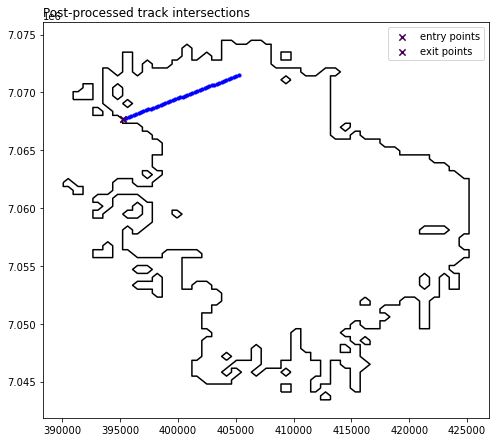

True True

			Flight ID:  N907KW_202107101815
			Origin at 2021-07-10 18:35:10 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.066 seconds.
			Terminus at 2021-07-10 18:37:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.063 seconds.


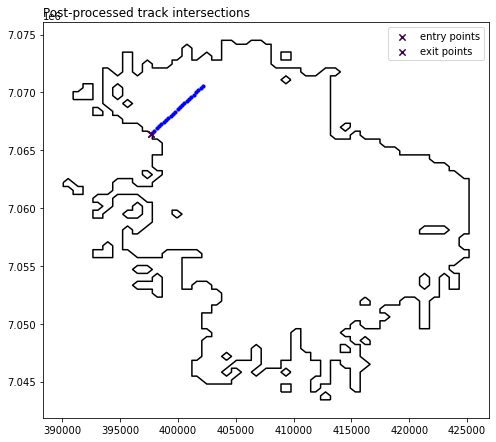

True True

			Flight ID:  N907KW_202107110830
			Origin at 2021-07-11 08:51:20 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.078 seconds.
			Terminus at 2021-07-11 08:54:45 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.062 seconds.


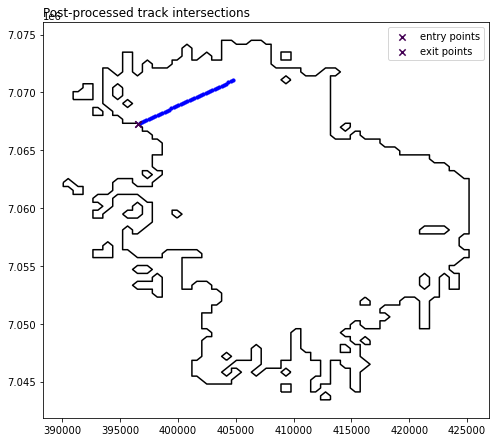

True True

			Flight ID:  N907KW_202107120830
			Origin at 2021-07-12 08:48:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.066 seconds.
			Terminus at 2021-07-12 08:50:10 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.062 seconds.


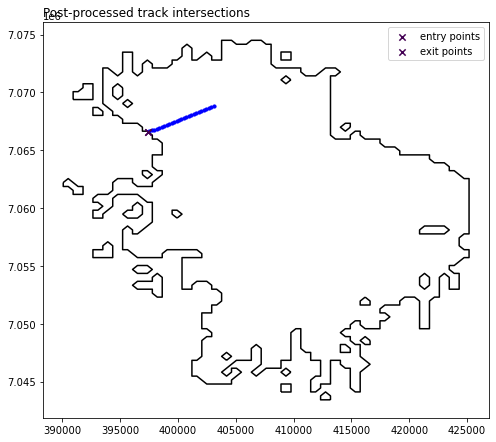

True True

			Flight ID:  N907KW_202107141200
			Origin at 2021-07-14 12:21:40 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.099 seconds.
			Terminus at 2021-07-14 12:26:05 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.068 seconds.


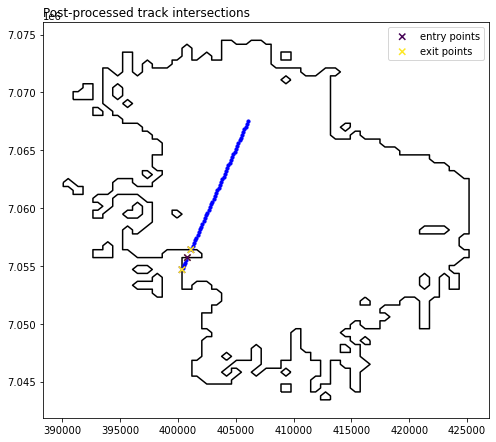

True True

			Flight ID:  N907KW_202107141515
			Origin at 2021-07-14 15:34:40 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.068 seconds.
			Terminus at 2021-07-14 15:40:20 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.064 seconds.


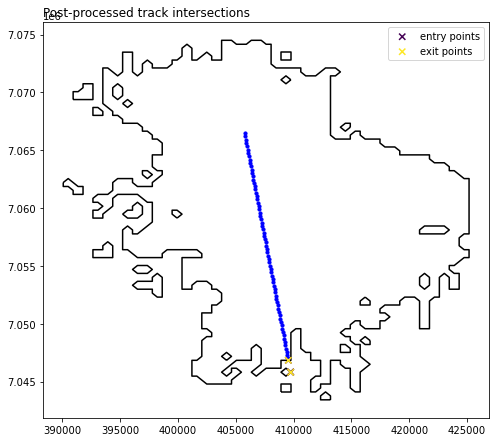

True True

			Flight ID:  N907KW_202107141815
			Origin at 2021-07-14 18:34:40 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.093 seconds.
			Terminus at 2021-07-14 18:38:30 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.074 seconds.


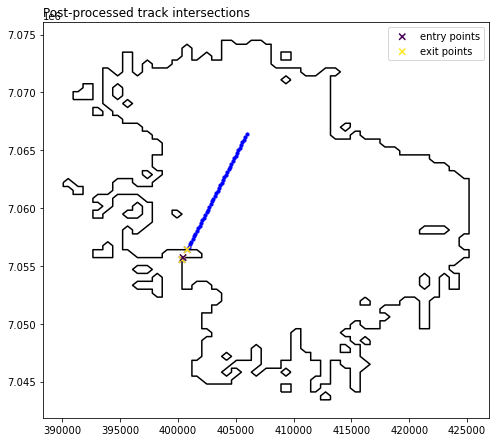

True True

			Flight ID:  N907KW_202107150730
			Origin at 2021-07-15 07:51:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.066 seconds.
			Terminus at 2021-07-15 07:56:20 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.070 seconds.


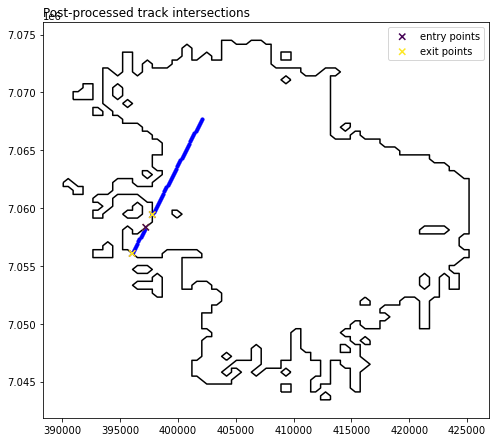

True True

			Flight ID:  N907KW_202107151100
			Origin at 2021-07-15 11:20:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.086 seconds.
			Terminus at 2021-07-15 11:24:55 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.080 seconds.


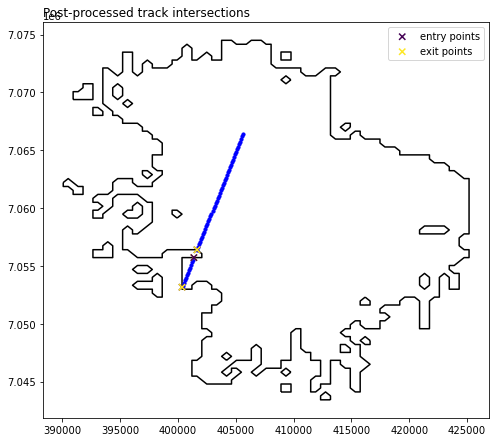

True True

			Flight ID:  N907KW_202107151230
			Origin at 2021-07-15 13:16:30 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.093 seconds.
			Terminus at 2021-07-15 13:20:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.072 seconds.


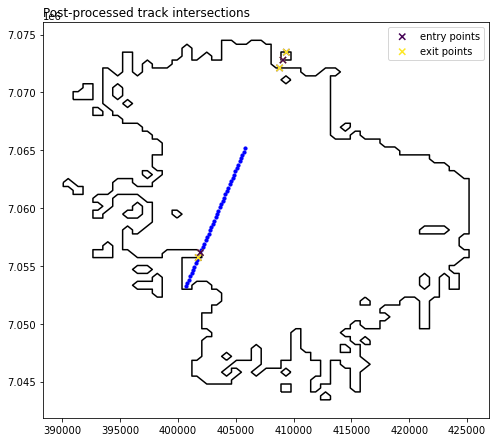

True True

			Flight ID:  N907KW_202107151400
			Origin at 2021-07-15 14:25:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.087 seconds.
			Terminus at 2021-07-15 14:29:55 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.078 seconds.


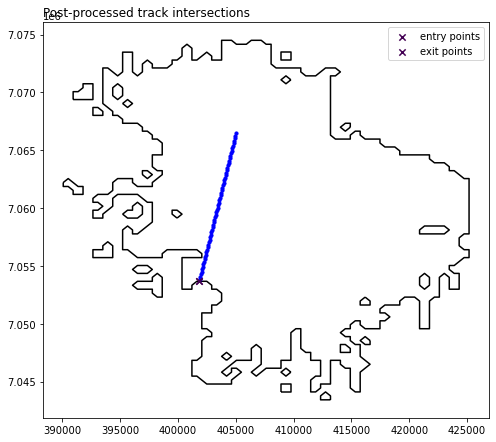

True True

			Flight ID:  N907KW_202107151715
			Origin at 2021-07-15 17:28:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.074 seconds.
			Terminus at 2021-07-15 17:33:20 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.069 seconds.


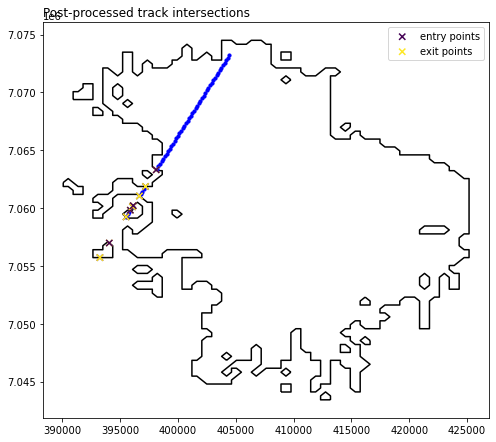

True True

			Flight ID:  N907KW_202107160730
			Origin at 2021-07-16 07:47:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.083 seconds.
			Terminus at 2021-07-16 07:49:20 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.072 seconds.


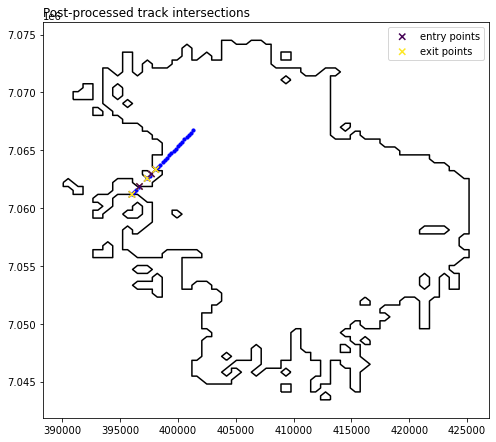

True True

			Flight ID:  N907KW_202107171100
			Origin at 2021-07-17 11:21:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.103 seconds.
			Terminus at 2021-07-17 11:23:50 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.081 seconds.


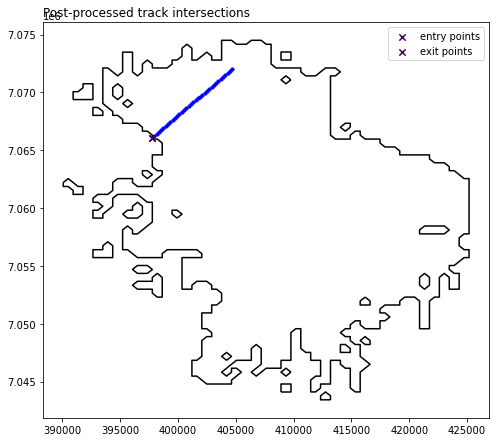

True True

			Flight ID:  N907KW_202107180730
			Origin at 2021-07-18 07:56:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.078 seconds.
			Terminus at 2021-07-18 07:58:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.115 seconds.


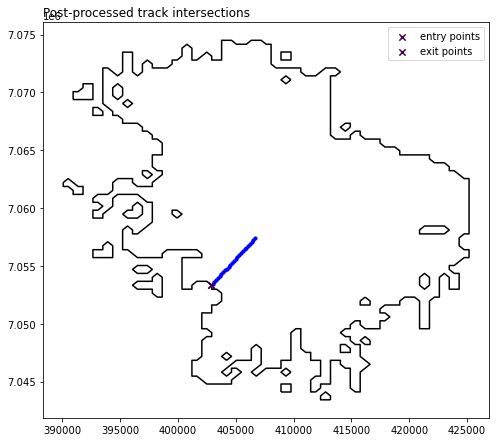

True True

			Flight ID:  N907KW_202107180900
			Origin at 2021-07-18 09:44:15 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.093 seconds.
			Terminus at 2021-07-18 09:48:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.146 seconds.


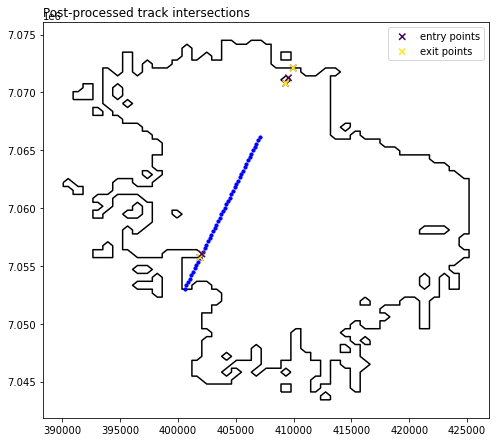

True True

			Flight ID:  N907KW_202107181115
			Origin at 2021-07-18 11:35:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.119 seconds.
			Terminus at 2021-07-18 11:43:50 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.092 seconds.


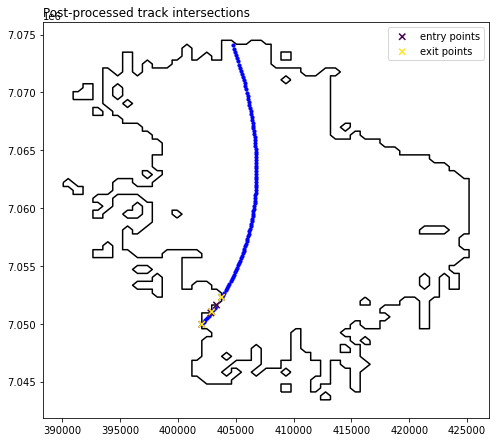

True True

			Flight ID:  N907KW_202107181415
			Origin at 2021-07-18 14:33:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.145 seconds.
			Terminus at 2021-07-18 14:39:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.108 seconds.


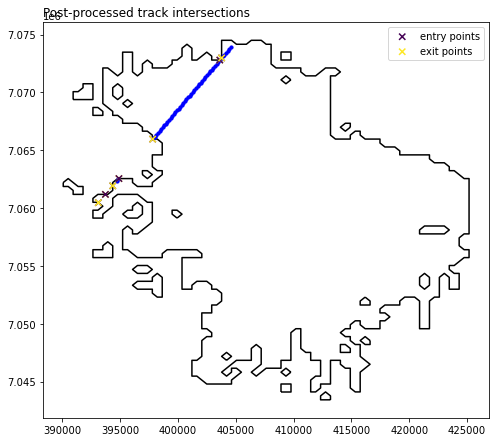

True True

			Flight ID:  N907KW_202107181545
			Origin at 2021-07-18 16:22:10 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.126 seconds.
			Terminus at 2021-07-18 16:26:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.076 seconds.


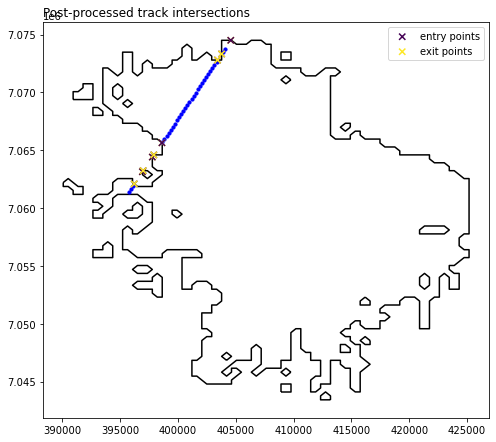

True True

			Flight ID:  N907KW_202107181715
			Origin at 2021-07-18 17:36:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.092 seconds.
			Terminus at 2021-07-18 17:39:55 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.101 seconds.


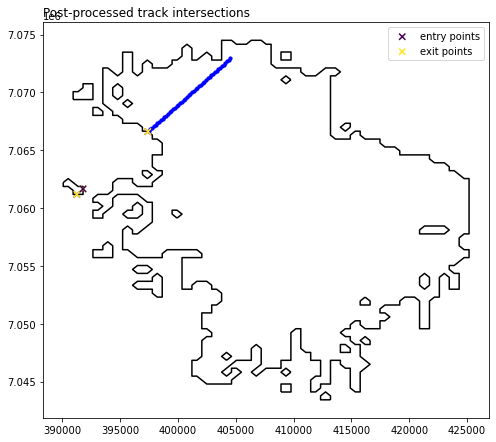

True True

			Flight ID:  N907KW_202107190730
			Origin at 2021-07-19 07:48:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.120 seconds.
			Terminus at 2021-07-19 07:53:40 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.078 seconds.


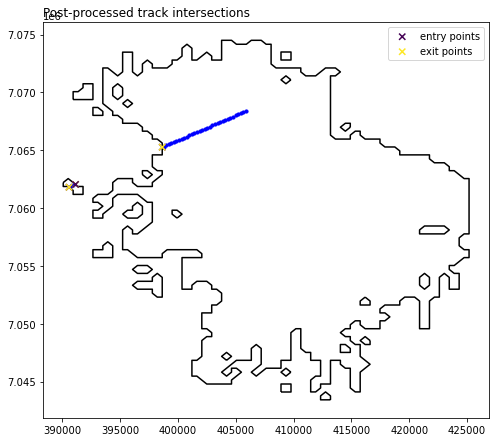

True True

			Flight ID:  N907KW_202107191415
			Origin at 2021-07-19 14:37:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.093 seconds.
			Terminus at 2021-07-19 14:42:05 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.082 seconds.


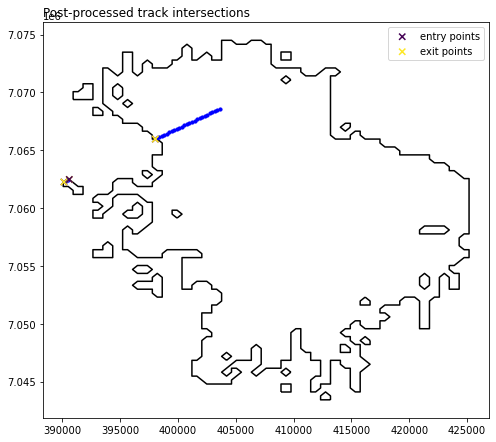

True True

			Flight ID:  N907KW_202107191715
			Origin at 2021-07-19 17:38:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.170 seconds.
			Terminus at 2021-07-19 17:46:40 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.087 seconds.


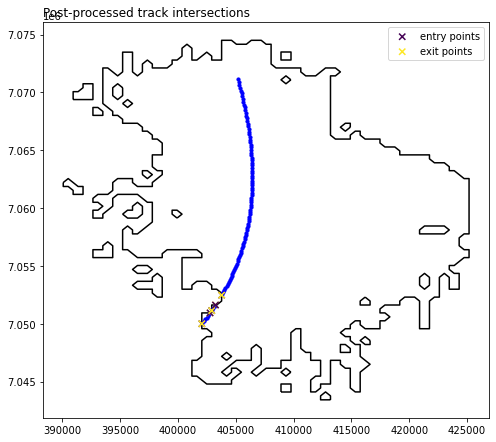

True True

			Flight ID:  N907KW_202107211715
			Origin at 2021-07-21 17:37:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.086 seconds.
			Terminus at 2021-07-21 17:40:25 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.077 seconds.


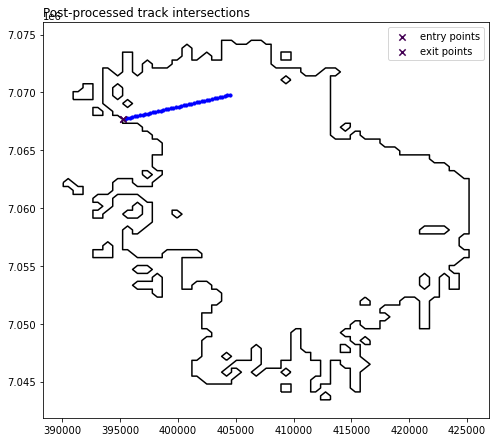

True True

			Flight ID:  N907KW_202107220745
			Origin at 2021-07-22 07:55:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.080 seconds.
			Terminus at 2021-07-22 07:58:25 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.080 seconds.


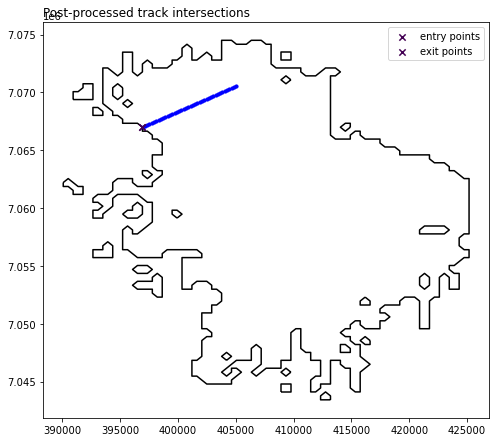

True True

			Flight ID:  N907KW_202107221415
			Origin at 2021-07-22 14:31:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.074 seconds.
			Terminus at 2021-07-22 14:35:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.069 seconds.


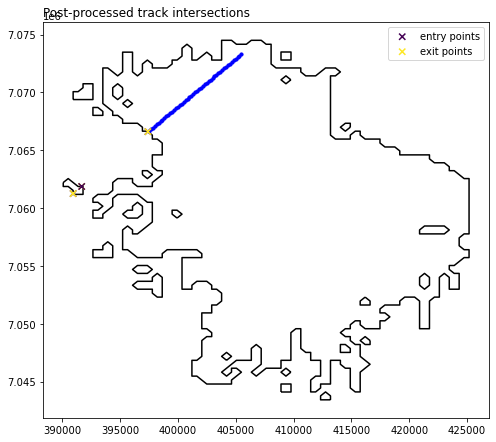

True True

			Flight ID:  N907KW_202107221715
			Origin at 2021-07-22 17:31:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.067 seconds.
			Terminus at 2021-07-22 17:34:30 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.081 seconds.


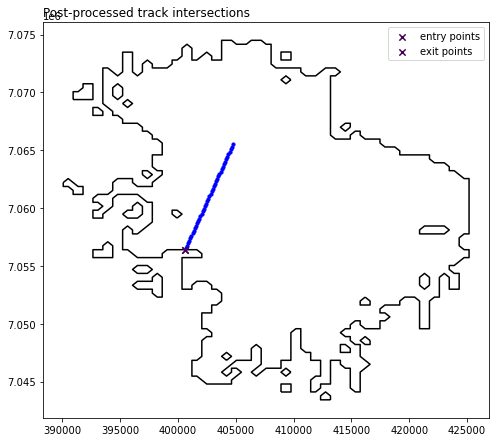

True True

			Flight ID:  N907KW_202107231415
			Origin at 2021-07-23 14:28:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.075 seconds.
			Terminus at 2021-07-23 14:34:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.088 seconds.


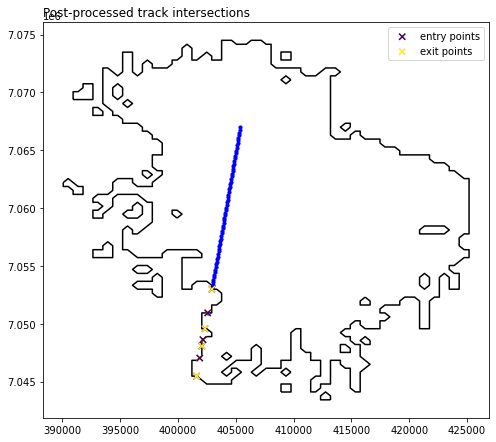

True True

			Flight ID:  N907KW_202107260730
			Origin at 2021-07-26 07:46:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.066 seconds.
			Terminus at 2021-07-26 07:51:20 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.093 seconds.


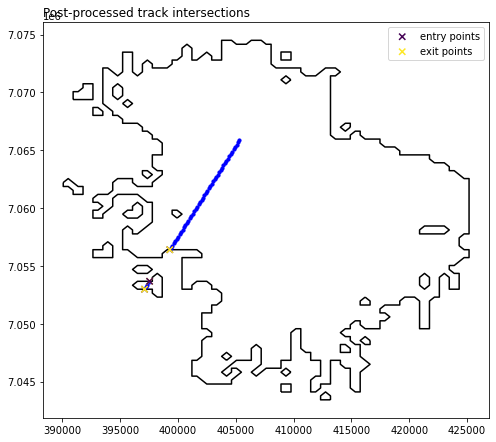

True True

			Flight ID:  N907KW_202107261715
			Origin at 2021-07-26 17:29:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.092 seconds.
			Terminus at 2021-07-26 19:26:00 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.067 seconds.


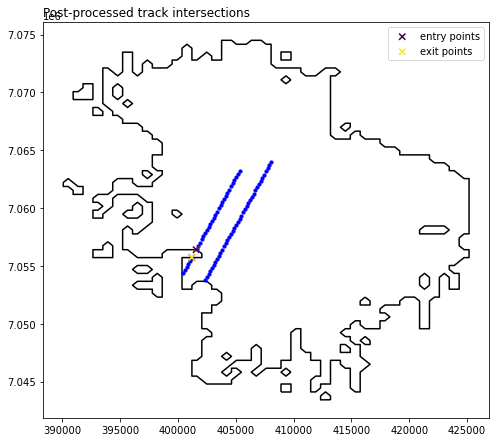

True True

			Flight ID:  N907KW_202107291430
			Origin at 2021-07-29 14:41:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.077 seconds.
			Terminus at 2021-07-29 14:44:30 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.063 seconds.


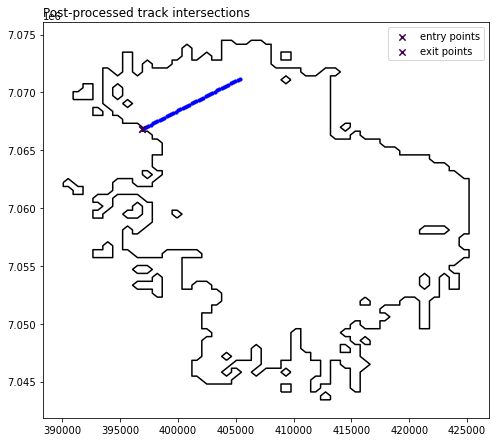

True True

			Flight ID:  N907KW_202107300745
			Origin at 2021-07-30 07:59:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.086 seconds.
			Terminus at 2021-07-30 08:03:20 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.078 seconds.


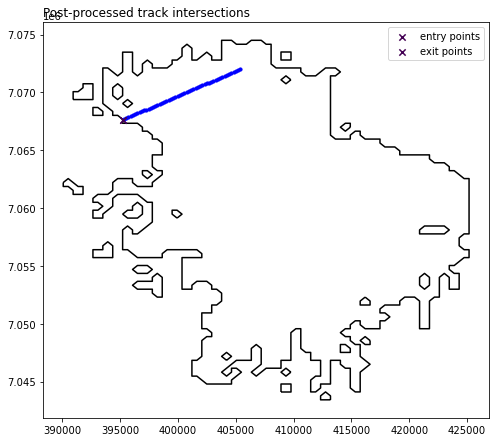

True True

			Flight ID:  N907KW_202107301730
			Origin at 2021-07-30 17:44:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.075 seconds.
			Terminus at 2021-07-30 17:49:15 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.066 seconds.


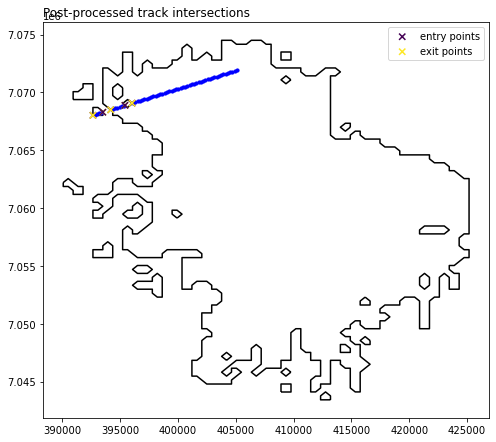

True True

			Flight ID:  N907KW_202107311715
			Origin at 2021-07-31 17:36:00 is inside the active space. Extrapolation required!

				We extrapolate the first two points backwards in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.099 seconds.
			Terminus at 2021-07-31 17:42:40 is inside the active space. Extrapolation required!

				We extrapolate the last two points forward in time:

In estimator
	Extrapolating to boundary... this may take a while...
			Calculating origin took 0.071 seconds.


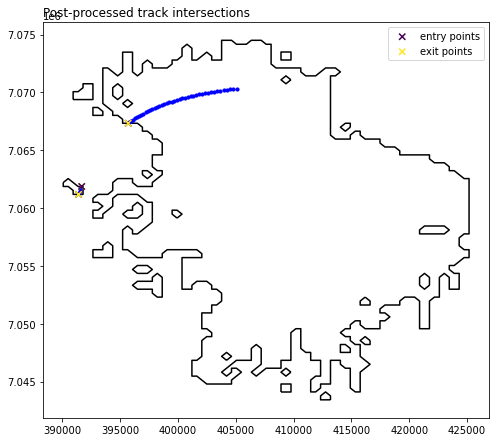

In [9]:
origin = gpd.GeoDataFrame([])
terminus = gpd.GeoDataFrame([])
intersections_ea['direction'] = 2

count = 0
for j, frame in grouped_ea:
    count += 1
    if frame.empty or len(frame['geometry']) < 2: #                CAN YOU EXPLAIN THESE CONDITIONS?
        print("Empty")
        continue
    else:
        # every interval has two caps (or boundaries)

        start_cap = frame['geometry'].iloc[0].within(active_ea.geometry.unary_union)
        cap_end = frame['geometry'].iloc[-1].within(active_ea.geometry.unary_union)
        print(start_cap, cap_end )

        t_avg, v_rms = caculate_speed_distance(frame)
        print('\n\t\t\tFlight ID: ', j)
        
        if start_cap:
            start = time.time()
            print("\t\t\tOrigin at", frame["DateTime"].iloc[0], "is inside the active space. Extrapolation required!\n")
            print("\t\t\t\tWe extrapolate the first two points backwards in time:\n")

            fwd = boundary_estimator(frame, cap_index=0, active_space_poly=active_ea, id=j,
                                          date_time=frame["DateTime"].iloc[0], t_avg=t_avg, v_rms=v_rms, key_order=[0,1])
            origin = origin.append(fwd, ignore_index=True)
            
            # intersections_ea = intersections_ea.append(origin, ignore_index=True)

            
            end = time.time()
            print(f"\t\t\tCalculating origin took {(end - start):.3f} seconds.")
        else:
            print("\t\t\tOrigin at", frame["DateTime"].iloc[0], "is outside the active space. No extrapolation needed.")

        if cap_end:
            start = time.time()
            print("\t\t\tTerminus at", frame["DateTime"].iloc[-1], "is inside the active space. Extrapolation required!\n")
            print("\t\t\t\tWe extrapolate the last two points forward in time:\n")
            
            bkwd = boundary_estimator(frame, cap_index=1, active_space_poly=active_ea, id=j,
                                          date_time=frame["DateTime"].iloc[len(frame) - 1], t_avg=t_avg, v_rms=v_rms, key_order = [1, 0])
            
            terminus = terminus.append(bkwd, ignore_index=True)
            
            # intersections_ea = intersections_ea.append(terminus, ignore_index=True)
            
            end = time.time()
            print(f"\t\t\tCalculating origin took {(end - start):.3f} seconds.")

        else:
            print("\t\t\tTerminus at",frame.iloc[-1]["DateTime"], "is outside the active space. No extrapolation needed.")
            # where are the entries and exit points along the active space?
        fig, ax = plt.subplots(1,1, figsize=(8,8))
        active_ea.boundary.plot(ax=ax, color="black", zorder=-1)
        # sA.boundary.plot(ax=ax, color="blue", ls="--", zorder=-2)
        frame.plot(ax=ax, markersize=10, color='blue', marker="o", zorder=-1)
        origin[origin['flight_id']  == j].plot(ax=ax, markersize=40, c=origin['direction'], marker="x", zorder=1, label="entry points")
        terminus[terminus['flight_id']  == j].plot(ax=ax, markersize=40, c=terminus['direction'], marker="x", zorder=1, label="exit points")
        ax.set_title("Post-processed track intersections", loc="left")
        ax.legend()
        # ax.set_aspect(simple_aspect)
        plt.show()
        plt.close()



In [10]:
origin

flight_id                   DateTime  \
0    N185AR_202105251000 2021-05-25 10:54:57.985312   
1    N185AR_202105251000 2021-05-25 11:00:57.107511   
2    N185AR_202105251000 2021-05-25 11:07:37.396688   
3    N185AR_202105251000 2021-05-25 11:14:49.105906   
4    N185AR_202105251000 2021-05-25 11:35:20.647665   
..                   ...                        ...   
439  N907KW_202107301730 2021-07-30 18:49:00.448404   
440  N907KW_202107301730 2021-07-30 19:02:09.699956   
441  N907KW_202107311715 2021-07-31 18:10:30.518101   
442  N907KW_202107311715 2021-07-31 18:43:43.692147   
443  N907KW_202107311715 2021-07-31 19:04:06.317530   

                           geometry  direction  
0    POINT (395712.410 7062553.210)          0  
1    POINT (397789.888 7064214.119)          1  
2    POINT (398275.237 7064602.562)          0  
3    POINT (398645.610 7064899.113)          1  
4    POINT (408058.554 7072467.258)          0  
..                              ...        ...  
439  POINT (395420.891 7068884.630)          1  
440  POINT (396036.116 7069076.618)          0  
441  POINT (391413.671 7061186.975)          0  
442  POINT (391686.581 7061870.092)          1  
443  POINT (395705.551 7067335.032)          0  

[444 rows x 4 columns]

In [11]:
# create a temporary column
intersections_ea['direction'] = 2

#merge all data frames
intersections_ea = intersections_ea.append(origin, ignore_index=True)
intersections_ea = intersections_ea.append(terminus, ignore_index=True)


intersections_ea

flight_id                   DateTime  \
0      N185AR_202105251000 2021-05-25 10:51:55.000000   
1      N185AR_202105251000 2021-05-25 10:52:00.000000   
2      N185AR_202105251000 2021-05-25 10:52:05.000000   
3      N185AR_202105251000 2021-05-25 10:52:10.000000   
4      N185AR_202105251000 2021-05-25 10:52:15.000000   
...                    ...                        ...   
10429  N907KW_202107301730 2021-07-30 17:38:38.465732   
10430  N907KW_202107301730 2021-07-30 17:31:25.762217   
10431  N907KW_202107311715 2021-07-31 17:41:31.789238   
10432  N907KW_202107311715 2021-07-31 17:40:06.708894   
10433  N907KW_202107311715 2021-07-31 17:15:15.576030   

                             geometry  direction  
0      POINT (393312.925 7060638.749)          2  
1      POINT (393552.541 7060829.745)          2  
2      POINT (393792.129 7061020.759)          2  
3      POINT (394031.687 7061211.791)          2  
4      POINT (394271.217 7061402.841)          2  
...                               ...        ...  
10429  POINT (395420.891 7068884.630)          0  
10430  POINT (396036.116 7069076.618)          1  
10431  POINT (391413.671 7061186.975)          1  
10432  POINT (391686.581 7061870.092)          0  
10433  POINT (395705.551 7067335.032)          1  

[10434 rows x 4 columns]

In [12]:
# extract just the entry and exit points
intersections_ea = intersections_ea.to_crs(active.crs)
# along with their timing
entries = []
entry_times = []
exits = []
exit_times = []
for idx, intersect in intersections_ea.iterrows():
    #entry times
    if intersect.direction == 0:
        entries.append(intersect.geometry)
        entry_times.append(intersect.DateTime)
    #exit times
    elif intersect.direction == 1:
        exits.append(intersect.geometry)
        exit_times.append(intersect.DateTime)
    else:
        continue
intersections_ea = intersections_ea.to_crs(utm_zone)

In [13]:
print(len(exits), len(entries))

444 444


In [14]:
grouped = intersections_ea.groupby('flight_id')
for id, group in grouped:
    local_points = []
    group.sort_values(by='DateTime',inplace=True)
    print(group.DateTime, group.direction)

9996   2021-05-25 09:27:40.893460
9995   2021-05-25 09:35:19.667609
9994   2021-05-25 09:42:06.651548
9993   2021-05-25 09:47:04.100395
9992   2021-05-25 10:02:10.364540
9991   2021-05-25 10:18:03.914352
9990   2021-05-25 10:34:59.418487
0      2021-05-25 10:51:55.000000
1      2021-05-25 10:52:00.000000
2      2021-05-25 10:52:05.000000
3      2021-05-25 10:52:10.000000
4      2021-05-25 10:52:15.000000
5      2021-05-25 10:52:20.000000
6      2021-05-25 10:52:25.000000
7      2021-05-25 10:52:30.000000
8      2021-05-25 10:52:35.000000
9      2021-05-25 10:52:40.000000
10     2021-05-25 10:52:45.000000
11     2021-05-25 10:53:30.000000
12     2021-05-25 10:53:35.000000
13     2021-05-25 10:53:50.000000
14     2021-05-25 10:53:55.000000
15     2021-05-25 10:54:00.000000
16     2021-05-25 10:54:05.000000
17     2021-05-25 10:54:10.000000
18     2021-05-25 10:54:15.000000
19     2021-05-25 10:54:20.000000
20     2021-05-25 10:54:25.000000
21     2021-05-25 10:54:30.000000
22     2021-05

                flight_id                   DateTime  \
9996  N185AR_202105251000 2021-05-25 09:27:40.893460   
9995  N185AR_202105251000 2021-05-25 09:35:19.667609   
9994  N185AR_202105251000 2021-05-25 09:42:06.651548   
9993  N185AR_202105251000 2021-05-25 09:47:04.100395   
9992  N185AR_202105251000 2021-05-25 10:02:10.364540   
9991  N185AR_202105251000 2021-05-25 10:18:03.914352   
9990  N185AR_202105251000 2021-05-25 10:34:59.418487   
0     N185AR_202105251000 2021-05-25 10:51:55.000000   
1     N185AR_202105251000 2021-05-25 10:52:00.000000   
2     N185AR_202105251000 2021-05-25 10:52:05.000000   
3     N185AR_202105251000 2021-05-25 10:52:10.000000   
4     N185AR_202105251000 2021-05-25 10:52:15.000000   
5     N185AR_202105251000 2021-05-25 10:52:20.000000   
6     N185AR_202105251000 2021-05-25 10:52:25.000000   
7     N185AR_202105251000 2021-05-25 10:52:30.000000   
8     N185AR_202105251000 2021-05-25 10:52:35.000000   
9     N185AR_202105251000 2021-05-25 10:52:40.00

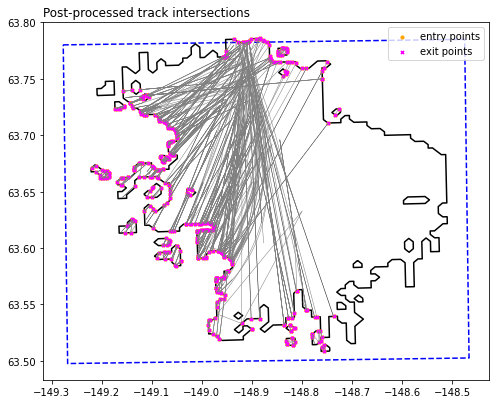


			Intersections have been determined! Took 18.908 seconds.





EVENTUALLY THE ACOUSTIC METRIC COMPUTATIONS WILL HAPPEN HERE





	Analysis complete. The entire process took 146.746 seconds.



In [15]:
grouped = intersections_ea.groupby('flight_id')


lines = []

for id, group in grouped:
    local_points = []
    group.sort_values(by='DateTime',inplace=True)
    print(group)
    for g in group.geometry:
        coords = np.array(g)
        if g.type == 'Point':
            lat_lon = coords.reshape(-1, 2)
        elif g.type == 'Multipoint':
            lat_lon = coords
        local_points.extend([tuple(row) for row in lat_lon])
    
    if len(local_points) >= 2:
        lines.append({
            'flight_id': id, 
            'geometry': LineString(local_points), 
            'DateTime': group.DateTime.values
        })

# Finalize into geopandas dataframe
# and transform back into geographic co-ordinates (WGS-84)
final_intersections_ea = gpd.GeoDataFrame(lines, crs=utm_zone)
final_intersections = final_intersections_ea.to_crs(active.crs)


    
# organize the information as two `gpd.GeoSeries` objects
enter = gpd.GeoSeries(entries, index=entry_times)
exit = gpd.GeoSeries(exits, index=exit_times)
final_intersections = gpd.overlay(final_intersections, active, how='intersection')
final_intersections_ea.to_crs(utm_zone)


if(draw_plots):
    
    # where are the entries and exit points along the active space?
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    active.boundary.plot(ax=ax, color="black", zorder=-1)
    studyA.boundary.plot(ax=ax, color="blue", ls="--", zorder=-2)
    final_intersections.plot(ax=ax, color="gray", markersize=1, lw=0.5, zorder=0)
    enter.plot(ax=ax, markersize=10, color="orange", marker="o", zorder=-1, label="entry points")
    exit.plot(ax=ax, markersize=10, color="magenta", marker="x", zorder=-1, label="exit points")
    ax.set_title("Post-processed track intersections", loc="left")
    ax.legend()
    ax.set_aspect(simple_aspect)
    plt.show()

end = time.time()
print(f"\n\t\t\tIntersections have been determined! Took {(end - start):.3f} seconds.\n")

print("\n\n\n\nEVENTUALLY THE ACOUSTIC METRIC COMPUTATIONS WILL HAPPEN HERE\n\n\n\n")

end_full = time.time()
print(f"\n\tAnalysis complete. The entire process took {(end_full - start_full):.3f} seconds.\n")


In [16]:
intersections_ea[intersections_ea['flight_id'] == 'N185AR_202106111515']

flight_id                   DateTime  \
401    N185AR_202106111515 2021-06-11 15:40:30.000000   
402    N185AR_202106111515 2021-06-11 15:40:35.000000   
403    N185AR_202106111515 2021-06-11 15:40:40.000000   
404    N185AR_202106111515 2021-06-11 15:40:45.000000   
405    N185AR_202106111515 2021-06-11 15:40:50.000000   
406    N185AR_202106111515 2021-06-11 15:40:55.000000   
407    N185AR_202106111515 2021-06-11 15:41:00.000000   
408    N185AR_202106111515 2021-06-11 15:41:05.000000   
409    N185AR_202106111515 2021-06-11 15:41:10.000000   
410    N185AR_202106111515 2021-06-11 15:41:15.000000   
411    N185AR_202106111515 2021-06-11 15:41:20.000000   
412    N185AR_202106111515 2021-06-11 15:41:25.000000   
413    N185AR_202106111515 2021-06-11 15:41:30.000000   
414    N185AR_202106111515 2021-06-11 15:41:35.000000   
415    N185AR_202106111515 2021-06-11 15:41:40.000000   
416    N185AR_202106111515 2021-06-11 15:41:45.000000   
417    N185AR_202106111515 2021-06-11 15:41:50.000000   
418    N185AR_202106111515 2021-06-11 15:41:55.000000   
419    N185AR_202106111515 2021-06-11 15:42:00.000000   
420    N185AR_202106111515 2021-06-11 15:42:05.000000   
421    N185AR_202106111515 2021-06-11 15:42:10.000000   
422    N185AR_202106111515 2021-06-11 15:42:15.000000   
423    N185AR_202106111515 2021-06-11 15:42:20.000000   
424    N185AR_202106111515 2021-06-11 15:42:25.000000   
425    N185AR_202106111515 2021-06-11 15:42:30.000000   
426    N185AR_202106111515 2021-06-11 15:42:35.000000   
427    N185AR_202106111515 2021-06-11 15:42:40.000000   
428    N185AR_202106111515 2021-06-11 15:42:45.000000   
429    N185AR_202106111515 2021-06-11 15:42:50.000000   
430    N185AR_202106111515 2021-06-11 15:42:55.000000   
431    N185AR_202106111515 2021-06-11 15:43:00.000000   
432    N185AR_202106111515 2021-06-11 15:43:05.000000   
433    N185AR_202106111515 2021-06-11 15:43:10.000000   
434    N185AR_202106111515 2021-06-11 15:43:15.000000   
435    N185AR_202106111515 2021-06-11 15:43:20.000000   
436    N185AR_202106111515 2021-06-11 15:43:25.000000   
437    N185AR_202106111515 2021-06-11 15:43:30.000000   
438    N185AR_202106111515 2021-06-11 15:43:35.000000   
439    N185AR_202106111515 2021-06-11 15:43:40.000000   
440    N185AR_202106111515 2021-06-11 15:43:45.000000   
441    N185AR_202106111515 2021-06-11 15:43:50.000000   
442    N185AR_202106111515 2021-06-11 15:43:55.000000   
443    N185AR_202106111515 2021-06-11 15:44:00.000000   
444    N185AR_202106111515 2021-06-11 15:44:05.000000   
9580   N185AR_202106111515 2021-06-11 15:52:53.587480   
10024  N185AR_202106111515 2021-06-11 15:43:34.408907   

                             geometry  direction  
401    POINT (405922.994 7060271.655)          2  
402    POINT (405796.127 7060103.120)          2  
403    POINT (405669.248 7059934.590)          2  
404    POINT (405542.356 7059766.065)          2  
405    POINT (405415.450 7059597.546)          2  
406    POINT (405288.532 7059429.031)          2  
407    POINT (405161.600 7059260.521)          2  
408    POINT (405034.655 7059092.016)          2  
409    POINT (404907.697 7058923.516)          2  
410    POINT (404780.727 7058755.021)          2  
411    POINT (404653.743 7058586.532)          2  
412    POINT (404526.746 7058418.047)          2  
413    POINT (404399.736 7058249.567)          2  
414    POINT (404272.712 7058081.092)          2  
415    POINT (404145.676 7057912.623)          2  
416    POINT (404018.627 7057744.158)          2  
417    POINT (403891.565 7057575.698)          2  
418    POINT (403764.489 7057407.244)          2  
419    POINT (403637.401 7057238.794)          2  
420    POINT (403510.299 7057070.350)          2  
421    POINT (403383.184 7056901.910)          2  
422    POINT (403256.057 7056733.475)          2  
423    POINT (403128.916 7056565.046)          2  
424    POINT (403001.762 7056396.622)          2  
425    POINT (402874.595 7056228.202)          2  
426    POIN

In [17]:
final_intersections

flight_id                                           DateTime  \
0    N185AR_202105251000  [2021-05-25T09:27:40.893460000, 2021-05-25T09:...   
1    N185AR_202105251700  [2021-05-25T16:07:12.082554000, 2021-05-25T16:...   
2    N185AR_202105252015  [2021-05-25T20:48:54.206365000, 2021-05-25T20:...   
3    N185AR_202105301815  [2021-05-30T18:24:16.938985000, 2021-05-30T18:...   
4    N185AR_202105301945  [2021-05-30T18:49:37.423350000, 2021-05-30T19:...   
..                   ...                                                ...   
143  N907KW_202107261715  [2021-07-20T23:58:32.886227000, 2021-07-23T19:...   
144  N907KW_202107291430  [2021-07-29T14:41:00.000000000, 2021-07-29T14:...   
145  N907KW_202107300745  [2021-07-30T07:59:00.000000000, 2021-07-30T07:...   
146  N907KW_202107301730  [2021-07-30T17:31:25.762217000, 2021-07-30T17:...   
147  N907KW_202107311715  [2021-07-31T17:15:15.576030000, 2021-07-31T17:...   

     altitude_m            mic_name  \
0          1141  DENATRLA2021O_+035   
1          1141  DENATRLA2021O_+035   
2          1141  DENATRLA2021O_+035   
3          1141  DENATRLA2021O_+035   
4          1141  DENATRLA2021O_+035   
..          ...                 ...   
143        1141  DENATRLA2021O_+035   
144        1141  DENATRLA2021O_+035   
145        1141  DENATRLA2021O_+035   
146        1141  DENATRLA2021O_+035   
147        1141  DENATRLA2021O_+035   

                                              geometry  
0    MULTILINESTRING ((-148.83951 63.77711, -148.84...  
1    MULTILINESTRING ((-148.90113 63.78524, -149.01...  
2    MULTILINESTRING ((-148.83015 63.77389, -148.83...  
3    MULTILINESTRING ((-149.10924 63.73504, -149.10...  
4    MULTILINESTRING ((-148.83851 63.77712, -148.84...  
..                                                 ...  
143  MULTILINESTRING ((-148.98565 63.62185, -148.98...  
144  MULTILINESTRING ((-148.91836 63.75556, -148.92...  
145  MULTILINESTRING ((-148.91806 63.76303, -148.92...  
146  MULTILINESTRING ((-149.10581 63.73391, -149.10...  
147  MULTILINESTRING ((-149.11134 63.71819, -149.11...  

[148 rows x 5 columns]

In [18]:
print(final_intersections.iloc[0].geometry)

MULTILINESTRING ((-148.8395134668795 63.77710787652254, -148.8475245451615 63.77407798794859), (-148.8475245451615 63.77407798794859, -148.8475245461901 63.77407798755936), (-148.8644622030988 63.76766836355337, -149.046798046335 63.69852246529265), (-149.046798046335 63.69852246529265, -149.0469829648785 63.69845233997569), (-149.0469829648785 63.69845233997569, -149.0469898120755 63.69844974336289), (-149.0469898120755 63.69844974336289, -149.0502818252289 63.69720133711135), (-149.0502818252289 63.69720133711135, -149.0502818282268 63.69720133597421), (-149.0575752690357 63.69443485647886, -149.0671306025318 63.69081058262087), (-149.0671306025318 63.69081058262087, -149.0671306056583 63.69081058143492), (-149.108005054636 63.67530598677433, -149.1551618 63.65741886666667, -149.1504552 63.65920413333333, -149.1457486 63.66098940000001, -149.141042 63.66277466666666, -149.1363354 63.66455993333334, -149.1316288 63.6663452, -149.1269222 63.66813046666669, -149.1222156 63.6699157333333

In [19]:
def calculate_duration(datetime_array):
    duration = pd.to_timedelta(max(datetime_array) - min(datetime_array))
    return duration.total_seconds()

# Calculate duration for each flight
final_intersections['duration_seconds'] = final_intersections['DateTime'].apply(calculate_duration)

In [20]:
def compute_metrics(column, quantile, df):
    print(f"Quantiles:\n{df[column].quantile(quantile)}\n")
    print(f"Mean Duration: {df[column].mean()}")
    print(f"Mean Absolute Deviation: {df[column].mad()}")
    print(f"Standard Deviation: {df[column].std()}")

In [21]:
print("Noise Event Duration")
compute_metrics('duration_seconds', [0.25, 0.5, 0.75], final_intersections)

Noise Event Duration
Quantiles:
0.25    1164.471806
0.50    3506.640705
0.75    6952.312677
Name: duration_seconds, dtype: float64

Mean Duration: 46017.421542432436
Mean Absolute Deviation: 80748.16244893608
Standard Deviation: 300879.1866320655


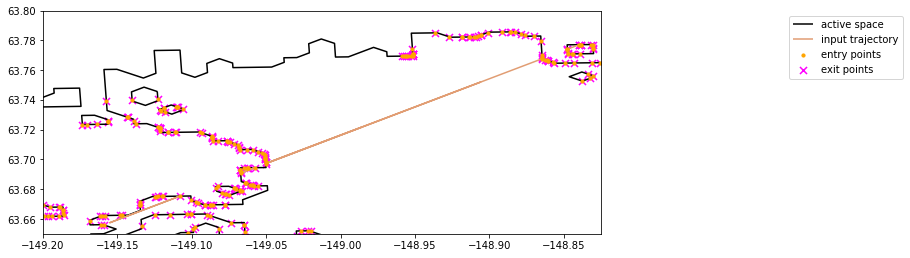

In [22]:
chunk = final_intersections[final_intersections['flight_id'] == 'N185AR_202105251000']
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_ylim([63.65, 63.80])
ax.set_xlim([-149.2, -148.825])
rand_colors = np.random.random(size=(len(chunk), 3))
active.boundary.plot(color="k", ax=ax, label="active space")
chunk.plot(color=rand_colors, ax=ax, markersize=50, label="input trajectory")
enter.plot(ax=ax, markersize=10, color="orange", marker="o", zorder=2, label="entry points")
exit.plot(ax=ax, markersize=50, color="magenta", marker="x", zorder=1, label="exit points")
ax.legend(bbox_to_anchor=(1.55, 1.0))
plt.show()

## Step 3: Compute (Attributive) Acoustic Metrics 

We use the term *attributive* because we are computing these metrics given tracks potentially representing a subset of the overall transportation system. We expect our results to differ from cumulative analyses - such as results derived from an acoustic record - in proportion to the subset's throughput when compared to the transportation system throughput as a whole.

### We must be capable of performing analyses at *three temporal scales*: <font color="salmon">overall</font>, <font color="orange">by day</font>, and <font color="green">by hour</font>.

----

## Metric types:

#### Spatial mitigation

>median distance from site <br> 
>median distance from inaudibility <br>

#### Duration
precursor `duration_list`, return:
>noise event duration list <br>
>quantile, mad, mean, std Event duration


#### Noise-free Intervals
precursor `NFI_list`, return:
>noise-free interval duration list <br>
>quantile, mad, mean, std NFI duration <br>
>longest NFI in a given summary period <br>
>longest NFI in a given summary period exceeds $t_{thresh}$


#### Audibility
>overall TA (%) <br>
>quantile, mad Daily TA (%) <br>
>mean, std Daily TA (%) <br>
>quantile, mad Hourly TA (%) <br>
>mean, std Hourly TA (%)

#### Event Rates
>overall Event count <br>
>quantile, mad Daily Events <br>
>mean, std Daily Events <br>
>quantile, mad Hourly Events <br>
>mean, std Hourly Events

 
#### Specific Park Standards
>ATMP-related standards? <br>
>ZION standards <br>
>DENA PA standard <br>
>DENA Events standard

In [ ]:
import geopandas as gpd
from shapely.geometry import MultiLineString

gdf = final_intersections

for index, row in gdf.iterrows():
    geometry = row['geometry']
    date_times = row['DateTime']

    if isinstance(geometry, MultiLineString):
        total_noise_free_duration = 0
        for i in range(len(geometry) - 1):
            end_point_datetime = date_times[len(geometry[i].coords) - 1]
            
            start_point_datetime_next_line = date_times[len(geometry[i].coords)]
            
            noise_free_interval = start_point_datetime_next_line - end_point_datetime
            
            noise_free_interval_seconds = noise_free_interval / np.timedelta64(1, 's')
            total_noise_free_duration += noise_free_interval_seconds
        
        total_duration = (date_times[-1] - date_times[0]) / np.timedelta64(1, 's')
        
        percentage_noise_free = (total_noise_free_duration / total_duration) * 100
        
        print(f"Trajectory {index} is {percentage_noise_free:.2f}% noise-free.")


In [ ]:
print("\t\tSummarizing results.\n\t\tGenerating boolean audibility array, this may take a while...")
start = time.time()

# convert the boundaries of the evaluation period into true `dt.datetime` objects
start_dt = dt.datetime.strptime(start_date, "%Y-%m-%d")
end_dt = dt.datetime.strptime(end_date, "%Y-%m-%d")

# an array containing every second of the record as datetime
all_seconds = np.array([start_dt + dt.timedelta(seconds=i) for 
                        i in range(int((end_dt - start_dt).total_seconds()))])

# organize the intervals into an (n, 2) array
noise_intervals = np.array([[b, e] for b,e in zip(enter.index.to_pydatetime(), 
                                                  exit.index.to_pydatetime())])

# a boolean array the same length as the record
within_times = np.zeros(all_seconds.shape)

# ...and create a `pd.Series` that unites time with audibility status
aud_binary = pd.Series(within_times, index=all_seconds)

end = time.time()
print(f"\t\t\tGenerating the boolean array took {(end - start):.3f} seconds.\n")
print("\t\tTransforming audibility results...")
start = time.time()

for noise_event in tqdm(noise_intervals, unit="intervals"):

    try:

        # convert the enter/exit times into integer indices
        ind_begin = np.argwhere(all_seconds == noise_event[0])[0][0]
        ind_end = np.argwhere(all_seconds == noise_event[1])[0][0]

        # set values between the two indices equal to 'True'
        within_times[ind_begin:ind_end] = 1.0

    except IndexError:
        pass # basically the event had no duration

# finally, we reduce:

# first, reduce by finding the times where vehicles were not in the active space (i.e., inaudibility)
# and do a bit of rearranging to arrive at (geometric) NFI values
nfi_bounds = contiguous_regions(aud_binary.values == 0)
NFI_list = (nfi_bounds.T[1] - nfi_bounds.T[0])

# then, reduce by finding times where vehicles were in the active space (i.e., audibility)
noise_bounds = contiguous_regions(aud_binary.values == 1)
TA_list = (noise_bounds.T[1] - noise_bounds.T[0])

# we'll also summarize the durations of each unique aircraft event
# which is usually not possible with the microphone, alone
simplify_times = lambda t: t.total_seconds()
simple = np.vectorize(simplify_times)
duration_list = simple(noise_intervals.T[1] - noise_intervals.T[0]).astype('int')

end = time.time()
print(f"\t\t\tTransformed in {(end - start):.3f} seconds. TO DO NEXT... TRUE SUMMARIES!\n\n\n\n\n")

# TA_list, duration_list, NFI_list # a list of noise event and noise-free interval durations

		Summarizing results.
		Generating boolean audibility array, this may take a while...
			Generating the boolean array took 23.004 seconds.

		Transforming audibility results...


100%|██████████| 444/444 [01:26<00:00,  5.11intervals/s]

			Transformed in 87.034 seconds. TO DO NEXT... TRUE SUMMARIES!







#### A template sketch for one of several summary metric procedural functions
will eventually be used on both `duration_list` and `NFI_list` at different time scales

In [ ]:
t_thresh = 8500.0
# mean, standard deviation, median, median absolute deviation, number of intervals exceeding threshold, percentage exceeding
M,std,m,mad,nE,pE = summarize_duration(NFI_list, dur_threshold=t_thresh) 

print("The mean interval lasted {0} ± {1}.\nThe typical (median) interval lasted {2} ± {3}.\nA total of {4} intervals ({5:.1f}%) exceeded the {6} threshold.".format(dt.timedelta(seconds=int(M)),
                                                                                                                                                                     dt.timedelta(seconds=int(std)),
                                                                                                                                                                     dt.timedelta(seconds=int(m)),
                                                                                                                                                                     dt.timedelta(seconds=int(mad)),
                                                                                                                                                                     int(nE),
                                                                                                                                                                     100*pE,
                                                                                                                                                                     dt.timedelta(seconds=int(t_thresh))))


The mean interval lasted 92 days, 0:00:00 ± 0:00:00.
The typical (median) interval lasted 92 days, 0:00:00 ± 0:00:00.
A total of 1 intervals (100.0%) exceeded the 2:21:40 threshold.


#### A template sketch for finer temporal scales using `pd.Grouper`
For <font color="orange">**daily** </font> analyses we group using `freq="1 D"`</font> and for <font color="green">**hourly** </font> analyses using `freq="1 H"`</font> 

In [ ]:
# to implement finer time resolution 
for meta, t_block in aud_binary.groupby(pd.Grouper(freq="1 D", axis=0)):
    
    print("This analysis block begins at", meta)

    # we perform 
    nfi_bounds = contiguous_regions(t_block.values == 0)
    NFI_list = (nfi_bounds.T[1] - nfi_bounds.T[0])

    noise_bounds = contiguous_regions(t_block.values == 1)
    duration_list = (noise_bounds.T[1] - noise_bounds.T[0])
    
    print("\tNFIs")
    print("\t", NFI_list)
    
    print("\tDurations")
    print("\t", duration_list)

This analysis block begins at 2021-05-01 00:00:00
	NFIs
	 [86400]
	Durations
	 []
This analysis block begins at 2021-05-02 00:00:00
	NFIs
	 [86400]
	Durations
	 []
This analysis block begins at 2021-05-03 00:00:00
	NFIs
	 [86400]
	Durations
	 []
This analysis block begins at 2021-05-04 00:00:00
	NFIs
	 [86400]
	Durations
	 []
This analysis block begins at 2021-05-05 00:00:00
	NFIs
	 [86400]
	Durations
	 []
This analysis block begins at 2021-05-06 00:00:00
	NFIs
	 [86400]
	Durations
	 []
This analysis block begins at 2021-05-07 00:00:00
	NFIs
	 [86400]
	Durations
	 []
This analysis block begins at 2021-05-08 00:00:00
	NFIs
	 [86400]
	Durations
	 []
This analysis block begins at 2021-05-09 00:00:00
	NFIs
	 [86400]
	Durations
	 []
This analysis block begins at 2021-05-10 00:00:00
	NFIs
	 [86400]
	Durations
	 []
This analysis block begins at 2021-05-11 00:00:00
	NFIs
	 [86400]
	Durations
	 []
This analysis block begins at 2021-05-12 00:00:00
	NFIs
	 [86400]
	Durations
	 []
This analysis bl